In [ ]:
"""
A class to represent a web scraper for Douban movie short comments.

Note:
Crawling data requires time and bypassing the anti-crawling mechanism,
so it takes time and cannot be successful every time.

to get the same data,
you should run the code and input the same movie id:
23748525、26268494、27072327、34780991、26794435、1422063
and the same number of pages:20
"""
import time
import pandas as pd
import random
from datetime import datetime
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import json

class DoubanMovieSpider:
    def __init__(self):
        """
        Initializes the web scraper by setting up the Chrome WebDriver with specific options
        to bypass detection and handle cookies.
        """
        try:
            # Configure Chrome options to enhance stealth and performance
            self.chrome_options = Options()
            
            # Add arguments to disable sandbox, shared memory, GPU, and automation flags
            self.chrome_options.add_argument('--no-sandbox')
            self.chrome_options.add_argument('--disable-dev-shm-usage')
            self.chrome_options.add_argument('--disable-gpu')
            self.chrome_options.add_argument('--disable-blink-features=AutomationControlled')
            self.chrome_options.add_argument('--start-maximized')
            
            # Set a custom user agent to mimic a real browser
            self.chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')
            
            # Add experimental options to further disguise automation
            self.chrome_options.add_experimental_option('excludeSwitches', ['enable-automation'])
            self.chrome_options.add_experimental_option('useAutomationExtension', False)
            
            # Add argument to store credentials
            self.chrome_options.add_argument('--password-store=basic')
            
            # Initialize the WebDriver using a specific version of ChromeDriver
            service = Service()
            self.driver = webdriver.Chrome(service=service, options=self.chrome_options)
            
            # Execute Chrome DevTools Protocol (CDP) command to remove the webdriver property
            self.driver.execute_cdp_cmd('Page.addScriptToEvaluateOnNewDocument', {
                'source': '''
                    Object.defineProperty(navigator, 'webdriver', {
                        get: () => undefined
                    });
                    Object.defineProperty(navigator, 'plugins', {
                        get: () => [1, 2, 3, 4, 5]
                    });
                '''
            })
            
            # Set an explicit wait time for elements to load
            self.wait = WebDriverWait(self.driver, 15)
            
            # Attempt to load saved cookies; if unsuccessful, proceed to login
            if not self._load_cookies():
                self._login()
            
        except Exception as e:
            print(f"Error initializing Chrome driver: {str(e)}")
            if hasattr(self, 'driver'):
                self.driver.quit()
            raise

    def _login(self):
        """
        Handles the login process to Douban by navigating to the homepage,
        clicking the login button, and waiting for the user to complete login.
        """
        try:
            # Navigate to Douban homepage
            self.driver.get('https://www.douban.com')
            time.sleep(2)
            
            # Wait for and click the login button
            try:
                login_button = self.wait.until(
                    EC.element_to_be_clickable((By.CLASS_NAME, 'login'))
                )
                login_button.click()
            except:
                print("Login button not found, possibly already on login page")
            
            # Prompt user to complete login in the browser
            print("\nPlease complete the login process in the browser...")
            print("The program will continue automatically after successful login")
            
            # Wait for login success by checking for a specific element or URL change
            while True:
                try:
                    # Check for the presence of a user avatar element as a login success indicator
                    self.driver.find_element(By.CLASS_NAME, 'nav-user-account')
                    break
                except:
                    # Check if still on login-related pages
                    current_url = self.driver.current_url
                    if not any(domain in current_url for domain in ['accounts.douban.com', 'login']):
                        break
                    time.sleep(1)
            
            print("\nLogin successful!")
            
            # Save cookies after successful login
            self._save_cookies()
            
        except Exception as e:
            print(f"Error during login process: {str(e)}")
            raise

    def _save_cookies(self):
        """
        Saves the current session cookies to a file for future use.
        """
        cookies = self.driver.get_cookies()
        with open('douban_cookies.json', 'w') as f:
            json.dump(cookies, f)

    def _load_cookies(self):
        """
        Loads cookies from a file and adds them to the current session.
        
        @return: bool - True if cookies were successfully loaded, False otherwise.
        """
        try:
            with open('douban_cookies.json', 'r') as f:
                cookies = json.load(f)
                for cookie in cookies:
                    self.driver.add_cookie(cookie)
                return True
        except FileNotFoundError:
            return False

    def _random_scroll(self):
        """
        Simulates human-like scrolling by randomly scrolling the page a certain distance
        and pausing for a random amount of time.
        """
        scroll_pause_time = random.uniform(0.5, 2)
        scroll_length = random.randint(300, 700)
        self.driver.execute_script(f"window.scrollBy(0, {scroll_length});")
        time.sleep(scroll_pause_time)
        
    def _simulate_human_behavior(self):
        """
        Simulates human browsing behavior by performing random scrolls and pauses.
        """
        for _ in range(random.randint(1, 3)):
            self._random_scroll()
        time.sleep(random.uniform(1, 3))

    def get_comments(self, movie_id, max_pages=10):
        """
        Retrieves short comments for a specified movie from Douban.
        
        @param movie_id: The Douban ID of the movie.
        @param max_pages: The maximum number of pages to scrape.
        @return list: A list containing all the comment data.
        """
        comments = []
        percent_types = {
            'h': 'Positive',
            'm': 'Neutral', 
            'l': 'Negative'
        }
        
        # Visit the movie page once to load cookies
        self.driver.get(f'https://movie.douban.com/subject/{movie_id}/')
        time.sleep(2)
        
        total_iterations = len(percent_types) * max_pages
        max_retries = 3  # Maximum number of retries
        
        with tqdm(total=total_iterations, desc="Overall Progress") as pbar:
            for percent_type, type_name in percent_types.items():
                empty_page_count = 0  # Count of consecutive empty pages
                for page in range(max_pages):
                    retry_count = 0
                    while retry_count < max_retries:
                        try:
                            url = f'https://movie.douban.com/subject/{movie_id}/comments?percent_type={percent_type}&start={page * 20}&limit=20&status=P&sort=new_score'
                            self.driver.get(url)
                            
                            # Check if login is required
                            if "login" in self.driver.current_url:
                                print("\nRe-login required...")
                                self._login()
                                self.driver.get(url)
                            
                            # Wait for comments to load or timeout
                            try:
                                self.wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'comment-item')))
                            except TimeoutException:
                                print(f"\nPage {page+1} load timeout, retrying...")
                                retry_count += 1
                                time.sleep(random.uniform(3, 5))
                                continue
                                
                            # Simulate human browsing behavior
                            self._simulate_human_behavior()
                            
                            # Retrieve comment elements
                            comment_items = self.driver.find_elements(By.CLASS_NAME, 'comment-item')
                            
                            # Handle empty page scenario
                            if not comment_items:
                                empty_page_count += 1
                                print(f"\n{type_name} Page {page+1} is empty")
                                
                                # If 3 consecutive pages are empty, assume end of comments
                                if empty_page_count >= 3:
                                    print(f"\n{type_name} 3 consecutive pages are empty, stopping scrape")
                                    pbar.update(max_pages - page)
                                    break
                                
                                # Otherwise, retry the current page
                                if retry_count < max_retries - 1:
                                    print("Waiting before retrying...")
                                    time.sleep(random.uniform(5, 8))
                                    retry_count += 1
                                    continue
                                else:
                                    pbar.update(1)
                                    break
                            
                            # Reset empty page count upon successful comment retrieval
                            empty_page_count = 0
                            
                            # Process comments
                            page_comments = []
                            for item in comment_items:
                                try:
                                    # Extract username
                                    username = item.find_element(By.CSS_SELECTOR, '.comment-info a').text
                                    
                                    # Extract rating
                                    try:
                                        rating = item.find_element(By.CLASS_NAME, 'rating')
                                        rating_class = rating.get_attribute('class')
                                        score = int(rating_class.split('allstar')[-1][:2]) // 10
                                    except NoSuchElementException:
                                        score = 'No Rating'
                                    
                                    # Extract comment text
                                    comment_text = item.find_element(By.CLASS_NAME, 'short').text
                                    
                                    # Extract comment time
                                    time_str = item.find_element(By.CLASS_NAME, 'comment-time').text
                                    
                                    # Extract number of likes
                                    try:
                                        votes = item.find_element(By.CLASS_NAME, 'votes')
                                        vote_count = int(votes.text)
                                    except (NoSuchElementException, ValueError):
                                        vote_count = 0
                                    
                                    # Extract IP address
                                    try:
                                        ip_address = item.find_element(By.CLASS_NAME, 'comment-location').text
                                    except NoSuchElementException:
                                        ip_address = ''
                                    
                                    comment_data = {
                                        'Username': username,
                                        'Rating': score,
                                        'Comment': comment_text,
                                        'Time': time_str,
                                        'IP Address': ip_address,
                                        'Likes': vote_count,
                                        'Comment Type': type_name
                                    }
                                    page_comments.append(comment_data)
                                except Exception as e:
                                    print(f"\nError parsing comment: {str(e)}")
                                    continue
                            
                            # Check the number of comments on the page
                            if len(page_comments) < 5:  # If fewer than 5 comments on a page
                                print(f"\n{type_name} Page {page+1} has an abnormal number of comments ({len(page_comments)}), retrying...")
                                if retry_count < max_retries - 1:
                                    retry_count += 1
                                    time.sleep(random.uniform(5, 8))
                                    continue
                            
                            # Add successfully retrieved comments
                            comments.extend(page_comments)
                            
                            # Update progress bar
                            pbar.set_description(f"Scraping {type_name} Page {page+1}")
                            pbar.update(1)
                            
                            # Random delay
                            time.sleep(random.uniform(2, 5))
                            break  # Successfully retrieved data, exit retry loop
                            
                        except Exception as e:
                            print(f'\nError scraping {type_name} Page {page+1}: {str(e)}')
                            retry_count += 1
                            if retry_count < max_retries:
                                print(f"Waiting before retrying attempt {retry_count + 1}...")
                                time.sleep(random.uniform(5, 10))
                            else:
                                pbar.update(1)
                                break
                    
                    # If consecutive empty pages are encountered, stop scraping for the current type
                    if empty_page_count >= 3:
                        break
        
        return comments
        
    def __del__(self):
        """
        Destructor to ensure the browser is closed when the object is deleted.
        """
        if hasattr(self, 'driver'):
            self.driver.quit()

    def save_to_csv(self, comments, filename):
        """
        Saves the comment data to a CSV file.
        
        @param comments: List of comment data.
        @param filename: The name of the file to save the data to.
        """
        print("\nSaving data to CSV file...")
        df = pd.DataFrame(comments)
        
        # Define the order of columns
        columns_order = {
            'Username': 'username',
            'Rating': 'rating',
            'Comment': 'comment',
            'Time': 'time',
            'IP Address': 'ip_location',
            'Likes': 'votes',
            'Comment Type': 'comment_type'
        }
        
        # Rename columns and arrange them in the specified order
        df = df.rename(columns=columns_order)
        df = df[list(columns_order.values())]
        
        df.to_csv(filename, index=False, encoding='utf-8-sig')

def crawl_comments(work_id):
    """
    Crawls positive, neutral, and negative comments for a specified work.
    
    @param work_id: The ID of the work.
    @return: A DataFrame containing all comments.
    """
    percent_types = {
        'h': 'Positive',
        'm': 'Neutral', 
        'l': 'Negative'
    }
    
    all_comments = []
    
    # Iterate over each type of comment
    for percent_type, type_name in percent_types.items():
        # Scrape 20 pages
        for page in range(1, 21):
            url = f'https://api.bilibili.com/x/v2/reply/main?next={page}&type=1&oid={work_id}&mode=3&percent_type={percent_type}'
            
            try:
                response = requests.get(url, headers=headers)
                data = response.json()
                
                if data['code'] == 0 and data['data']['replies']:
                    for reply in data['data']['replies']:
                        comment = {
                            'user_id': reply['member']['mid'],
                            'user_name': reply['member']['uname'],
                            'content': reply['content']['message'],
                            'time': datetime.fromtimestamp(reply['ctime']).strftime('%Y-%m-%d %H:%M:%S'),
                            'like': reply['like'],
                            'type': type_name
                        }
                        all_comments.append(comment)
                
                time.sleep(1)  # Add delay to avoid requests being too fast
                
            except Exception as e:
                print(f'Error scraping {type_name} Page {page}: {str(e)}')
                continue
    
    # Convert to DataFrame and save
    df = pd.DataFrame(all_comments)
    df.to_csv(f'comments_{work_id}.csv', index=False, encoding='utf-8-sig')
    return df

def main():
    """
    Main function: prompts the user for input and executes the web scraper.
    """
    print("Welcome to the Douban Movie Short Comment Scraper!")
    
    try:
        spider = DoubanMovieSpider()
        
        # Prompt user for movie ID
        movie_id = input("Please enter the movie ID (can be obtained from the Douban movie URL, e.g., 1292052): ")
        while True:
            try:
                max_pages = int(input("Please enter the number of pages to scrape (20 comments per page): "))
                if max_pages > 0:
                    break
                else:
                    print("The number of pages must be greater than 0, please re-enter")
            except ValueError:
                print("Please enter a valid number")
        
        print(f"\nStarting to scrape short comments for movie ID: {movie_id}...")
        comments = spider.get_comments(movie_id, max_pages)
        
        if comments:
            filename = f'Douban_Movie_{movie_id}_Comments.csv'
            spider.save_to_csv(comments, filename)
            print(f"\nScraping complete! A total of {len(comments)} comments were retrieved")
            print(f"Data has been saved to file: {filename}")
        else:
            print("\nNo comments were retrieved, please check if the movie ID is correct")
            
    except Exception as e:
        print(f"\nError running the program: {str(e)}")
    finally:
        if 'spider' in locals():
            spider.driver.quit()

if __name__ == '__main__':
    main()


Welcome to the Douban Movie Short Comment Scraper!

Please complete the login process in the browser...
The program will continue automatically after successful login

Login successful!


Step 1: Loading data from source files...
Loading files for series: Attack on Titan
  - Successfully loaded douban_comments_attacktitan_season1.csv with UTF-8 encoding
  - Successfully loaded douban_comments_attacktitan_season2.csv with UTF-8 encoding
  - Successfully loaded douban_comments_attacktitan_season3.csv with UTF-8 encoding
Loading files for series: Nezha
  - Successfully loaded douban_comments_nezha_1.csv with UTF-8 encoding
  - Successfully loaded douban_comments_nezha_2.csv with UTF-8 encoding
Loading files for series: FF7
  - Successfully loaded douban_comments_ff7.csv with UTF-8 encoding
Combined data shape: (6873, 6)

Step 2: Cleaning data...
Data shape before cleaning: (6873, 6)
Missing values count: 
rating         4
comment        4
time           6
votes          6
source_file    0
series         0
dtype: int64
Data shape after cleaning: (6454, 7)

Step 3: Adding pandemic period classification...
Reviews by pandemic period:
period
Pre-Pandemic     4022
Post-Pandemic

<Figure size 1200x600 with 0 Axes>

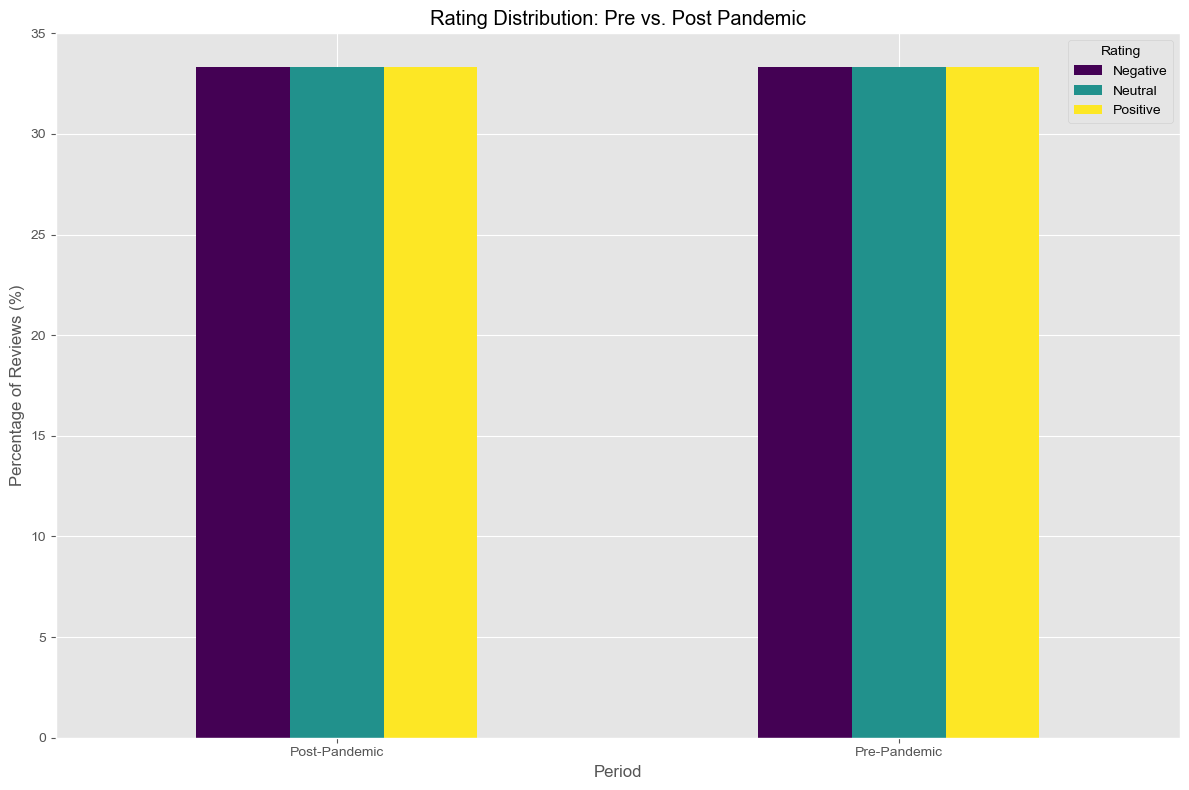

<Figure size 1800x1000 with 0 Axes>

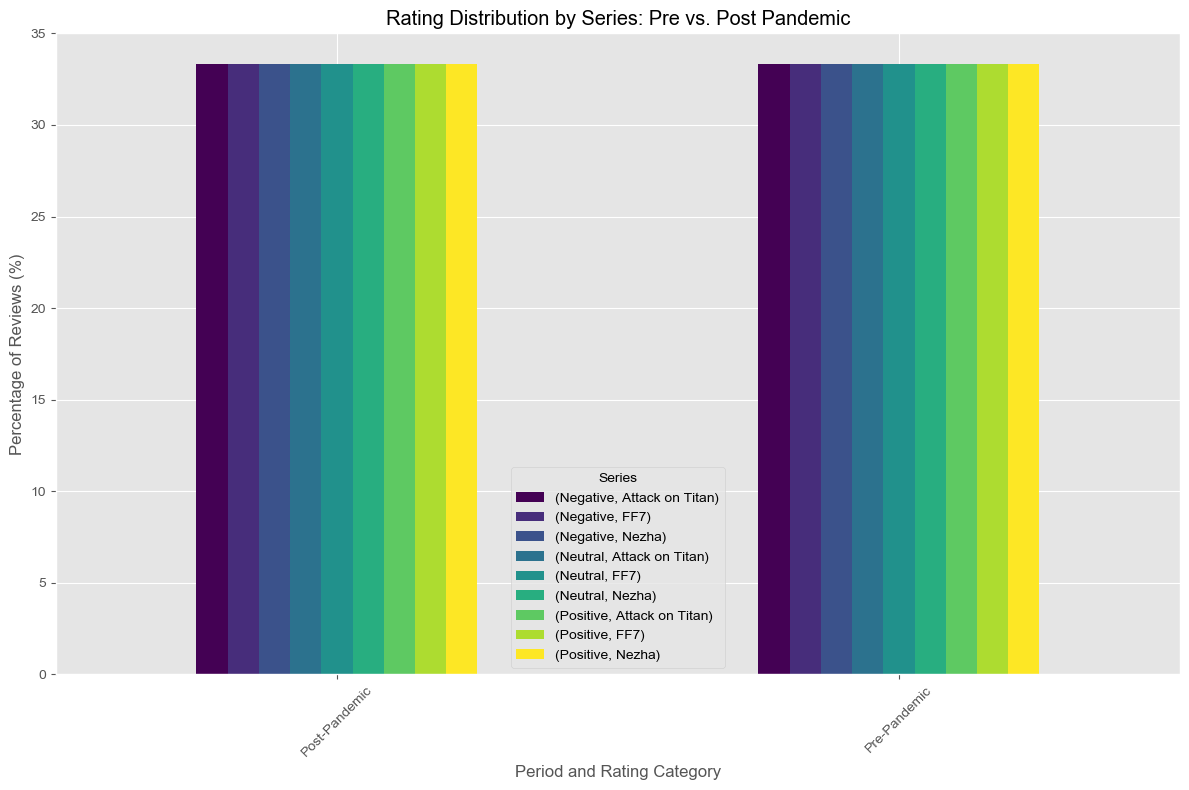


Step 7: Balanced dataset for pandemic comparison saved to /Users/leslie/data science 课程相关/critical data analysis final project/pandemic_comparison_data.csv

Step 8: Final dataset statistics:
Total balanced samples: 3600
Sample counts by dimension:
rating_category                Negative  Neutral  Positive
period        series                                      
Post-Pandemic Attack on Titan       200      200       200
              FF7                   200      200       200
              Nezha                 200      200       200
Pre-Pandemic  Attack on Titan       200      200       200
              FF7                   200      200       200
              Nezha                 200      200       200


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils import resample
import os
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Set the plot style to ggplot for better aesthetics
plt.style.use('ggplot')

"""
 * @description Configure matplotlib for better visualization
 * @details Sets up appropriate figure size and font configuration
 * @returns {boolean} True if successful, False otherwise
 """
def configure_plotting():
    # Set default figure size to 12x8 inches for better readability
    plt.rcParams['figure.figsize'] = (12, 8)
    
    # Use sans-serif fonts for consistent appearance across platforms
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Ensure proper display of minus signs on plots
    plt.rcParams['axes.unicode_minus'] = False
    
    return True

# Initialize plotting configuration at the start
configure_plotting()

"""
 * @description Load and merge data from multiple CSV files, organized by series
 * @details Attempts to read files with different encodings and adds series identification
 * @param {dict} file_paths_by_series - Dictionary mapping series names to lists of file paths
 * @returns {DataFrame} Merged dataframe containing all reviews with series identification
 """
def load_data(file_paths_by_series):
    # Initialize empty list to store individual dataframes
    dfs = []
    
    # Process each series and its associated files
    for series_name, file_paths in file_paths_by_series.items():
        print(f"Loading files for series: {series_name}")
        
        # Process each file in the current series
        for file_path in file_paths:
            try:
                # Try UTF-8 encoding first (most common)
                df = pd.read_csv(file_path, encoding='utf-8')
                print(f"  - Successfully loaded {os.path.basename(file_path)} with UTF-8 encoding")
            except UnicodeDecodeError:
                try:
                    # If UTF-8 fails, try GBK encoding (common for Chinese text)
                    df = pd.read_csv(file_path, encoding='gbk')
                    print(f"  - Successfully loaded {os.path.basename(file_path)} with GBK encoding")
                except:
                    # Last resort: try Latin-1 encoding (handles most characters)
                    df = pd.read_csv(file_path, encoding='latin1')
                    print(f"  - Successfully loaded {os.path.basename(file_path)} with Latin-1 encoding")
            
            # Add source file name as identifier (for traceability)
            df['source_file'] = os.path.basename(file_path)
            
            # Add series identification (key for analysis)
            df['series'] = series_name
            
            # Append to our collection of dataframes
            dfs.append(df)
    
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    
    return combined_df

"""
 * @description Clean the dataframe by handling missing values, duplicates, and text
 * @details Removes null rows, fills missing values, removes duplicates, and cleans text
 * @param {DataFrame} df - Input dataframe to clean
 * @returns {DataFrame} Cleaned dataframe ready for analysis
 """
def clean_data(df):
    # Create a copy to avoid modifying the original dataframe
    df_clean = df.copy()
    
    # Print initial shape and missing values summary
    print(f"Data shape before cleaning: {df_clean.shape}")
    print(f"Missing values count: \n{df_clean.isnull().sum()}")
    
    # Step 1: Remove rows where all columns are null (completely empty rows)
    df_clean.dropna(how='all', inplace=True)
    
    # Step 2: Remove rows with missing comments (essential for our analysis)
    df_clean.dropna(subset=['comment'], inplace=True)
    
    # Step 3: Fill missing values in other columns
    # For ratings: use 0 to indicate unrated
    if 'rating' in df_clean.columns:
        df_clean['rating'].fillna(0, inplace=True)
    
    # For votes: assume 0 votes if missing
    if 'votes' in df_clean.columns:
        df_clean['votes'].fillna(0, inplace=True)
    
    # For timestamps: use most common date if missing
    if 'time' in df_clean.columns:
        df_clean['time'].fillna(df_clean['time'].mode()[0], inplace=True)
    
    # Step 4: Remove duplicate comments with the same rating
    # (likely the same review appearing multiple times)
    df_clean.drop_duplicates(subset=['comment', 'rating'], inplace=True)
    
    # Step 5: Clean the comment text and create a cleaned version
    df_clean['comment'] = df_clean['comment'].astype(str)
    df_clean['comment_cleaned'] = df_clean['comment'].apply(clean_text)
    
    # Step 6: Ensure numerical columns have the correct data type
    # Convert votes to integers
    if 'votes' in df_clean.columns:
        df_clean['votes'] = pd.to_numeric(df_clean['votes'], errors='coerce').fillna(0).astype(int)
    
    # Convert ratings to numerical values
    if 'rating' in df_clean.columns:
        df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce').fillna(0)
    
    # Print final shape after cleaning
    print(f"Data shape after cleaning: {df_clean.shape}")
    
    return df_clean

"""
 * @description Clean text data by removing HTML tags, URLs, special characters, etc.
 * @details Performs multiple regex replacements to standardize text
 * @param {string} text - Input text to clean
 * @returns {string} Cleaned text for analysis
 """
def clean_text(text):
    # Step 1: Remove HTML tags (anything between < and >)
    text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Remove URLs (starting with http)
    text = re.sub(r'http\S+', '', text)
    
    # Step 3: Remove special characters (keep only alphanumeric and whitespace)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Step 4: Remove extra whitespace (multiple spaces, tabs, newlines)
    # and trim leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

"""
 * @description Add pandemic period flag to each review based on its date
 * @details Classifies reviews as pre/post-pandemic using the specified cutoff date
 * @param {DataFrame} df - Input dataframe with review dates
 * @param {string} time_col - Column name containing review timestamps
 * @param {string} cutoff_date - Pandemic cutoff date in format 'YYYY-MM-DD'
 * @returns {DataFrame} Dataframe with added pandemic period classification
 """
def add_pandemic_period(df, time_col='time', cutoff_date='2019-12-30'):
    # Create a copy to avoid modifying the original dataframe
    df_with_period = df.copy()
    
    # Step 1: Ensure time column is in datetime format
    # coerce=True converts invalid dates to NaT (Not a Time)
    df_with_period[time_col] = pd.to_datetime(df_with_period[time_col], errors='coerce')
    
    # Step 2: Convert cutoff date to datetime for comparison
    cutoff_datetime = pd.to_datetime(cutoff_date)
    
    # Step 3: Create pandemic period flag (0 = pre-pandemic, 1 = post-pandemic)
    # This creates a binary indicator based on the date comparison
    df_with_period['pandemic_period'] = (df_with_period[time_col] >= cutoff_datetime).astype(int)
    
    # Step 4: Create a readable period label (for reporting and visualization)
    df_with_period['period'] = df_with_period['pandemic_period'].map({
        0: 'Pre-Pandemic',
        1: 'Post-Pandemic'
    })
    
    # Step 5: Count reviews in each period (for reporting)
    period_counts = df_with_period['period'].value_counts()
    print(f"Reviews by pandemic period:\n{period_counts}")
    
    # Step 6: Check for missing dates and handle them
    missing_dates = df_with_period[time_col].isna().sum()
    if missing_dates > 0:
        print(f"Warning: {missing_dates} reviews have missing dates and will be excluded from period analysis")
        # Remove reviews with missing dates to ensure accurate period analysis
        df_with_period = df_with_period.dropna(subset=[time_col])
    
    return df_with_period

"""
 * @description Categorize numerical ratings into sentiment categories
 * @details Converts 1-5 scale ratings to Negative, Neutral, Positive categories
 * @param {DataFrame} df - Input dataframe with ratings
 * @returns {DataFrame} Dataframe with added rating categories
 """
def categorize_ratings(df):
    # Create a copy to avoid modifying the original dataframe
    df_cat = df.copy()
    
    # Check if rating column exists in the dataframe
    if 'rating' in df_cat.columns:
        # Ensure rating is in numerical format (convert from string if needed)
        df_cat['rating'] = pd.to_numeric(df_cat['rating'], errors='coerce')
        
        # Define conditions for categorization:
        # - Ratings 1-2: Negative (poor reception)
        # - Rating 3: Neutral (moderate reception)
        # - Ratings 4-5: Positive (strong reception)
        conditions = [
            (df_cat['rating'] <= 2) & (df_cat['rating'] > 0),  # Negative (exclude 0, which means unrated)
            (df_cat['rating'] == 3),                           # Neutral
            (df_cat['rating'] >= 4) & (df_cat['rating'] <= 5)  # Positive
        ]
        
        # Define category labels corresponding to conditions
        choices = ['Negative', 'Neutral', 'Positive']
        
        # Create new column with rating categories using numpy's select function
        # This applies the conditions and assigns the corresponding choice
        df_cat['rating_category'] = np.select(conditions, choices, default='Unknown')
        
        # Count the distribution of categories (for reporting)
        category_counts = df_cat['rating_category'].value_counts()
        print(f"Rating categories distribution:\n{category_counts}")
    else:
        # If no rating column exists, add a default 'Unknown' category
        df_cat['rating_category'] = 'Unknown'
        print("Warning: No 'rating' column found. All reviews categorized as 'Unknown'.")
    
    return df_cat

"""
 * @description Balance the dataset for pandemic comparison analysis
 * @details Creates equal samples across series, rating categories, and pandemic periods
 * @param {DataFrame} df - Input dataframe with categorized data
 * @param {string} period_col - Column name containing pandemic period identifiers
 * @param {string} series_col - Column name containing series identifiers
 * @param {string} category_col - Column name containing rating categories
 * @param {int} samples_per_group - Target number of samples per group
 * @returns {DataFrame} Balanced dataframe for fair comparison
 """
def balance_data_for_pandemic_comparison(df, period_col='period', series_col='series', 
                                       category_col='rating_category', samples_per_group=200):
    # Initialize empty dataframe for balanced data
    balanced_df = pd.DataFrame()
    
    # Get unique values for each dimension
    periods = df[period_col].unique()
    series_list = df[series_col].unique()
    categories = ['Positive', 'Neutral', 'Negative']
    
    print(f"Balancing data across {len(periods)} periods, {len(series_list)} series, and {len(categories)} rating categories")
    
    # For each combination of period, series, and rating category, select samples
    for period in periods:
        for series_name in series_list:
            for category in categories:
                # Get data for current combination
                subset = df[(df[period_col] == period) & 
                            (df[series_col] == series_name) & 
                            (df[category_col] == category)]
                
                # Handle the case where no data exists for this combination
                if len(subset) == 0:
                    print(f"Warning: No data for {period}, {series_name}, {category}")
                    continue
                
                # Determine sampling strategy based on available data
                if len(subset) > samples_per_group:
                    # Case 1: Too many samples - downsample without replacement
                    balanced_subset = resample(
                        subset, 
                        replace=False,  # Sample without replacement
                        n_samples=samples_per_group,
                        random_state=42  # For reproducibility
                    )
                    print(f"  Downsampled {period}, {series_name}, {category}: {len(subset)} → {samples_per_group}")
                elif len(subset) < samples_per_group:
                    # Case 2: Too few samples - upsample with replacement
                    balanced_subset = resample(
                        subset, 
                        replace=True,  # Sample with replacement
                        n_samples=samples_per_group,
                        random_state=42  # For reproducibility
                    )
                    print(f"  Upsampled {period}, {series_name}, {category}: {len(subset)} → {samples_per_group}")
                else:
                    # Case 3: Exactly right number of samples - use as is
                    balanced_subset = subset
                    print(f"  Kept all {len(subset)} samples for {period}, {series_name}, {category}")
                
                # Add balanced subset to final dataframe
                balanced_df = pd.concat([balanced_df, balanced_subset])
    
    # Verify balance by creating a cross-tabulation
    print("\nSamples per group after balancing:")
    balance_table = pd.crosstab(
        [balanced_df[period_col], balanced_df[series_col]], 
        balanced_df[category_col]
    )
    print(balance_table)
    
    return balanced_df

"""
 * @description Analyze rating distributions by pandemic period
 * @details Creates comparative visualizations and tables of rating distributions
 * @param {DataFrame} df - Input dataframe with period and rating data
 * @param {string} period_col - Column name containing pandemic period
 * @param {string} series_col - Column name containing series name
 * @param {string} rating_col - Column name containing rating categories
 * @returns {None}
 """
def analyze_pandemic_impact(df, period_col='period', series_col='series', rating_col='rating_category'):
    # Create cross-tabulation of period vs. rating categories (as percentages)
    # normalize='index' converts counts to percentages across rows
    period_ratings = pd.crosstab(df[period_col], df[rating_col], normalize='index') * 100
    
    # Create cross-tabulation of period vs. rating categories for each series
    series_period_ratings = pd.crosstab([df[series_col], df[period_col]], df[rating_col], normalize='index') * 100
    
    # Print tabular results for easy interpretation
    print("Overall rating distribution by pandemic period (%):")
    print(period_ratings)
    
    print("\nRating distribution by series and pandemic period (%):")
    print(series_period_ratings)
    
    # Visualize the results
    try:
        # Create overall pandemic impact visualization
        plt.figure(figsize=(12, 6))
        period_ratings.plot(kind='bar', colormap='viridis')
        plt.title('Rating Distribution: Pre vs. Post Pandemic')
        plt.xlabel('Period')
        plt.ylabel('Percentage of Reviews (%)')
        plt.legend(title='Rating')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Create series-specific pandemic impact visualization
        plt.figure(figsize=(18, 10))
        series_period_ratings.unstack(level=0).plot(kind='bar', colormap='viridis')
        plt.title('Rating Distribution by Series: Pre vs. Post Pandemic')
        plt.xlabel('Period and Rating Category')
        plt.ylabel('Percentage of Reviews (%)')
        plt.legend(title='Series')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        # Handle any visualization errors gracefully
        print(f"Error creating visualization: {e}")
        print("Please refer to the tabular data above")

# Define file paths organized by series
# Base directory where all files are located
base_dir = '/Users/leslie/data science 课程相关/critical data analysis final project/'

# Group files by series - this structure helps organize the data loading
file_paths_by_series = {
    'Attack on Titan': [
        base_dir + 'douban_comments_attacktitan_season1.csv',
        base_dir + 'douban_comments_attacktitan_season2.csv',
        base_dir + 'douban_comments_attacktitan_season3.csv'
    ],
    'Nezha': [
        base_dir + 'douban_comments_nezha_1.csv',
        base_dir + 'douban_comments_nezha_2.csv'
    ],
    'FF7': [
        base_dir + 'douban_comments_ff7.csv'
    ]
}

# Step 1: Load data from all source files
print("Step 1: Loading data from source files...")
df = load_data(file_paths_by_series)

# Step 2: Clean the data (handle missing values, duplicates, etc.)
print("\nStep 2: Cleaning data...")
df_clean = clean_data(df)

# Step 3: Add pandemic period flags (pre/post Dec 30, 2019)
print("\nStep 3: Adding pandemic period classification...")
df_with_period = add_pandemic_period(df_clean, 'time', '2019-12-30')

# Step 4: Categorize ratings (1-2 → Negative, 3 → Neutral, 4-5 → Positive)
print("\nStep 4: Categorizing ratings...")
df_categorized = categorize_ratings(df_with_period)

# Step 5: Balance the dataset for pandemic comparison
print("\nStep 5: Balancing dataset for pandemic comparison...")
# Target 200 samples per series per rating category per period
balanced_df = balance_data_for_pandemic_comparison(df_categorized, 'period', 'series', 'rating_category', 200)

# Step 6: Analyze pandemic impact on ratings
print("\nStep 6: Analyzing pandemic impact on ratings...")
analyze_pandemic_impact(balanced_df)

# Step 7: Save the balanced dataset for further analysis
output_path = base_dir + 'pandemic_comparison_data.csv'
balanced_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nStep 7: Balanced dataset for pandemic comparison saved to {output_path}")

# Step 8: Print final summary statistics
print("\nStep 8: Final dataset statistics:")
print(f"Total balanced samples: {len(balanced_df)}")
print("Sample counts by dimension:")
print(pd.crosstab([balanced_df['period'], balanced_df['series']], balanced_df['rating_category']))

Step 0: Checking and installing required packages...
SnowNLP is not installed. Attempting to install...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 17.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=17599bf6a340d17c36da9f773ac1fe5be2932fcc2bdb89fd5faf96d956703ce6
  Stored in directory: /Users/leslie/Library/Caches/pip/wheels/8a/0a/37/f15b8568f5463f1427466f701e9d3ba514035eb703f885efee
Successfully built snownlp
SnowNLP has been successfully installed.

Step 1: Loading balanced dataset...
Loaded dataset with shape: (3600, 10)
All required columns found in the dataset.

Step 2: Performing sentiment analysis...
Performing sentiment analysis on 3600 reviews...
Processed 100/3600 comments (2.8%) - Speed: 419.03 comments/second
Processed 200/3600 comments (5.6%) - Speed: 365.76 comments/second
Processed 300/

<Figure size 1000x600 with 0 Axes>

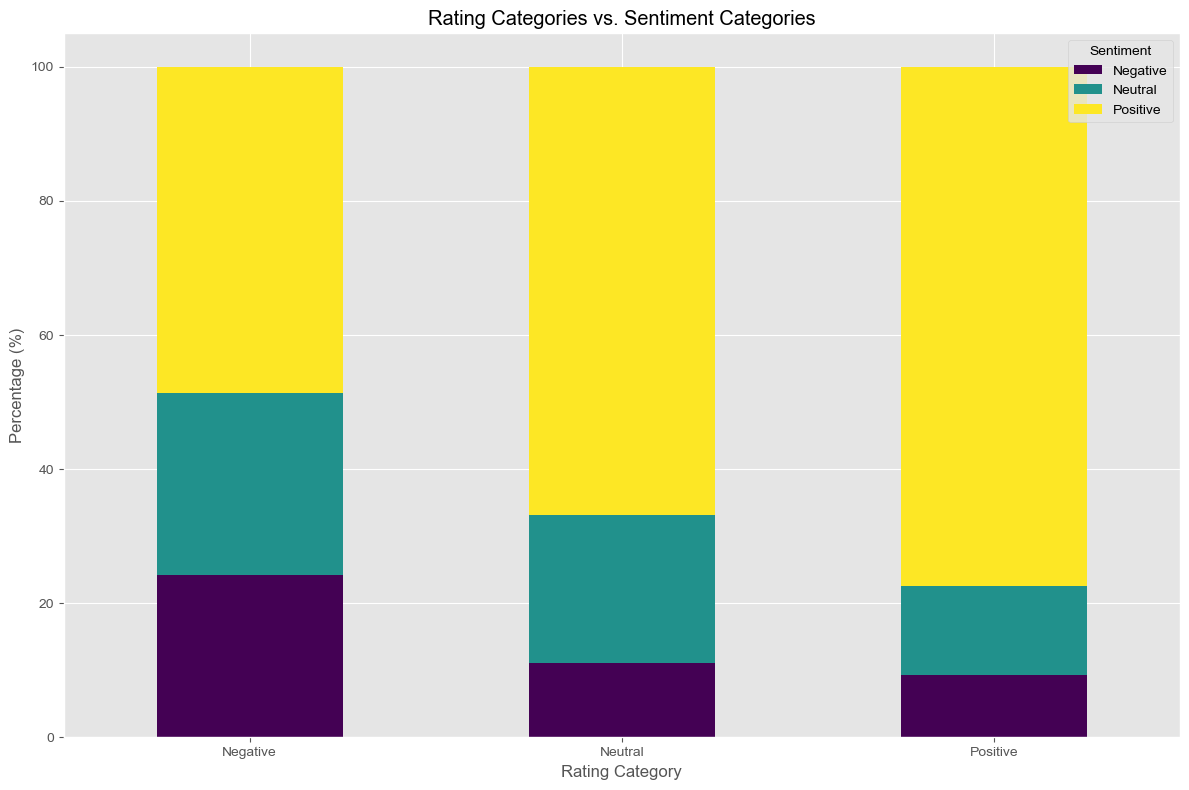


Step 4: Analyzing sentiment changes before and after pandemic...
Average sentiment score by pandemic period:
period
Post-Pandemic    0.751842
Pre-Pandemic     0.719162
Name: sentiment_score, dtype: float64

Sentiment category distribution by pandemic period (%):
sentiment_category   Negative    Neutral   Positive
period                                             
Post-Pandemic       14.555556  19.055556  66.388889
Pre-Pandemic        15.166667  22.611111  62.222222

Sentiment category distribution by series and pandemic period (%):
sentiment_category              Negative    Neutral   Positive
series          period                                        
Attack on Titan Post-Pandemic  17.166667  20.333333  62.500000
                Pre-Pandemic   18.000000  26.666667  55.333333
FF7             Post-Pandemic  12.333333  23.333333  64.333333
                Pre-Pandemic   12.500000  29.000000  58.500000
Nezha           Post-Pandemic  14.166667  13.500000  72.333333
                Pre

<Figure size 1200x600 with 0 Axes>

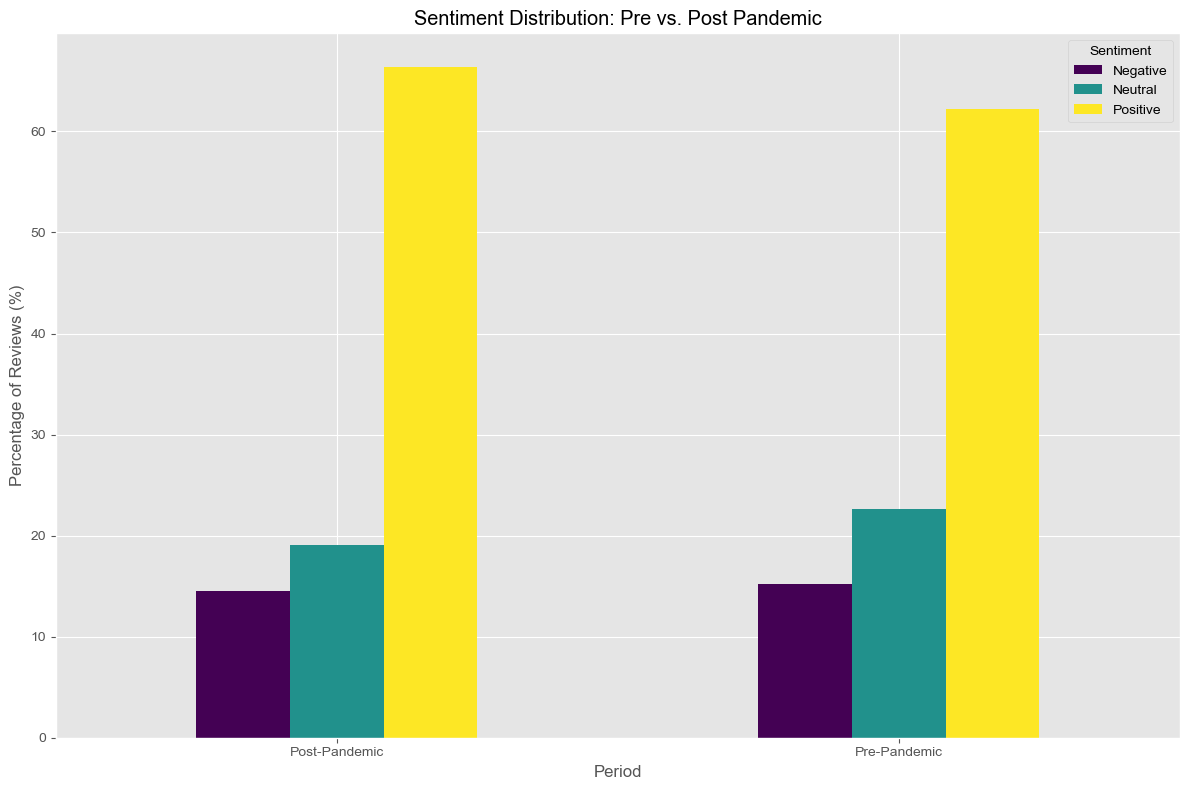

<Figure size 1800x1000 with 0 Axes>

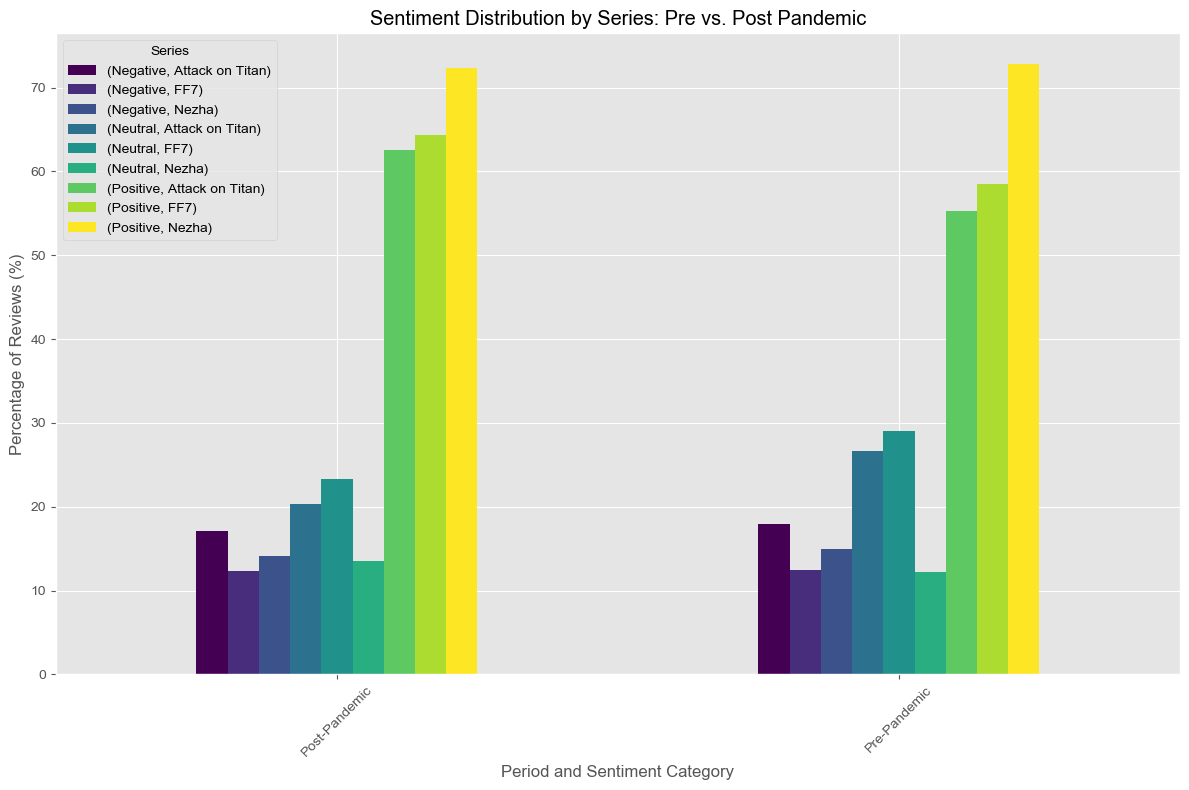

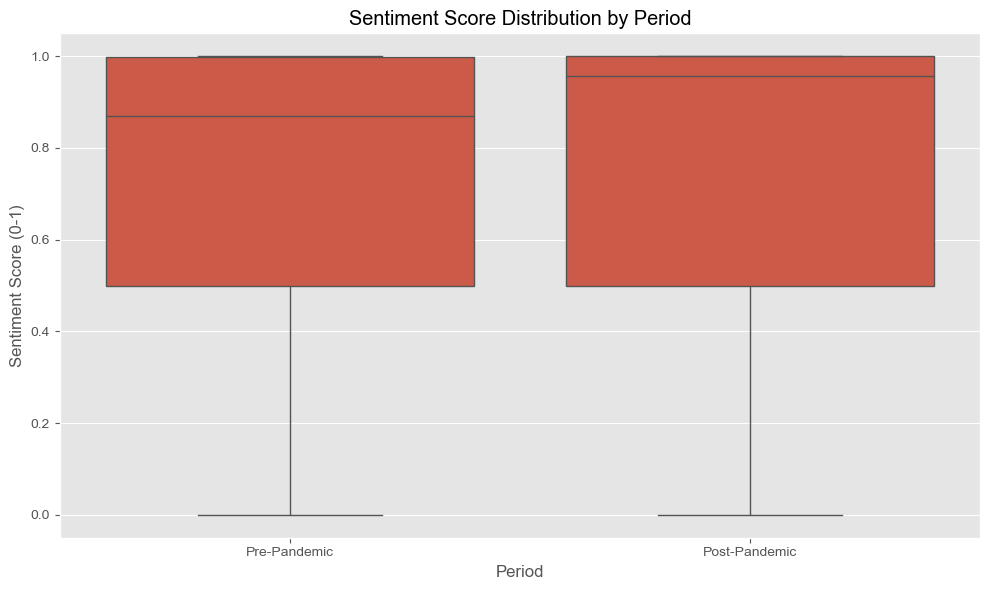

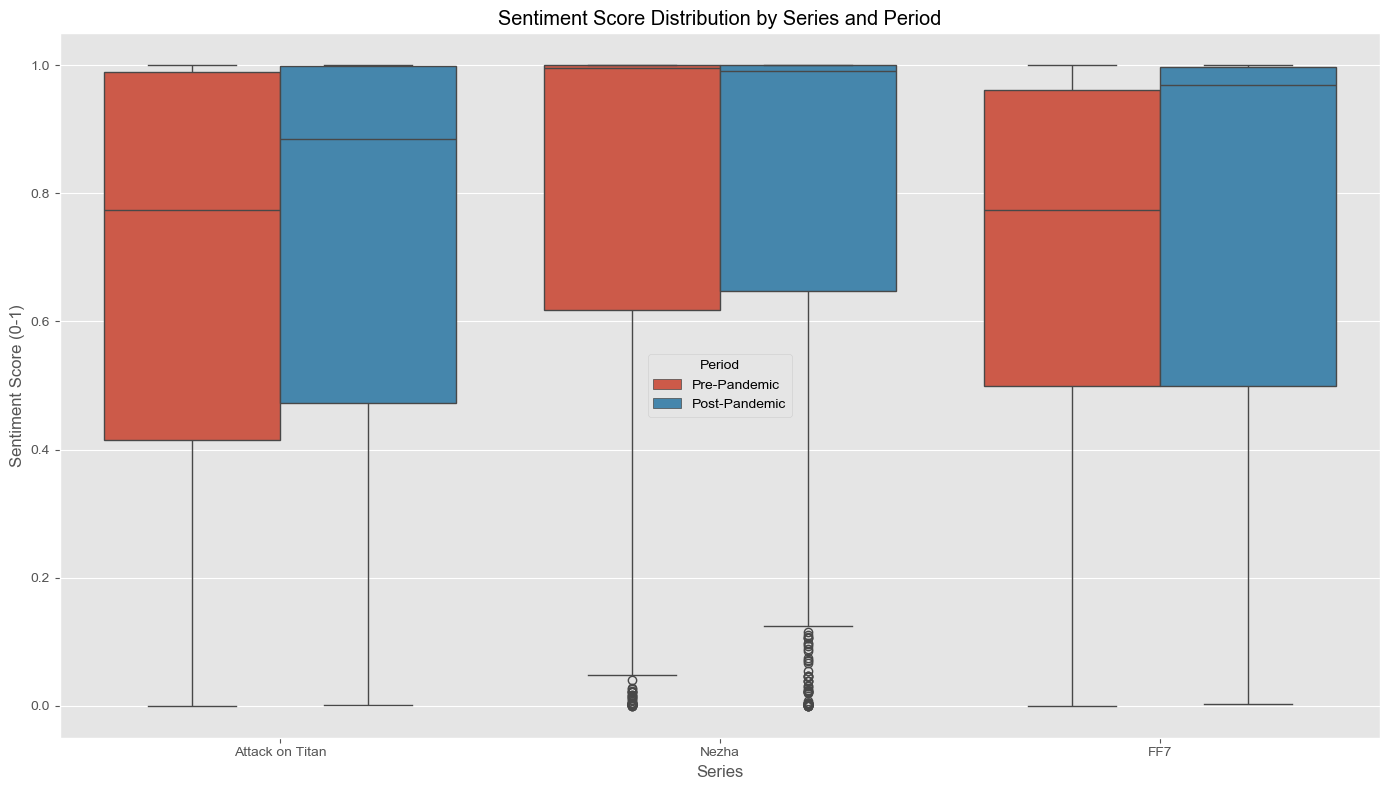


Step 5: Dataset with sentiment analysis saved to /Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv

Step 6: Sentiment analysis summary:
Total reviews analyzed: 3600
Average sentiment score: 0.7355
Median sentiment score: 0.9136
Sentiment score range: 0.0000 - 1.0000

Sentiment category distribution:
sentiment_category
Positive    64.305556
Neutral     20.833333
Negative    14.861111
Name: proportion, dtype: float64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import sys
warnings.filterwarnings('ignore')  # Suppress warning messages

# Set the plot style for better visualization
plt.style.use('ggplot')

"""
 * @description Install required packages if not already installed
 * @details Attempts to install SnowNLP and provides feedback
 * @returns {boolean} True if successful, False otherwise
 """
def install_required_packages():
    try:
        # Try importing SnowNLP first to check if it's already installed
        import snownlp
        print("SnowNLP is already installed.")
        return True
    except ImportError:
        print("SnowNLP is not installed. Attempting to install...")
        
        try:
            # Import pip to use for installation
            import pip
            
            # Use subprocess to run pip install in a shell
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "snownlp"])
            
            # Check if installation was successful
            import snownlp
            print("SnowNLP has been successfully installed.")
            return True
        except Exception as e:
            print(f"Failed to install SnowNLP: {str(e)}")
            print("Please install manually by running: pip install snownlp")
            return False

"""
 * @description Configure matplotlib for better visualization
 * @details Sets appropriate figure size and font configurations
 * @returns {boolean} Success indicator
 """
def configure_plotting():
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.unicode_minus'] = False
    return True

# Initialize plotting configuration
configure_plotting()

"""
 * @description Calculate SnowNLP sentiment score for a text
 * @details Uses SnowNLP to generate a sentiment score between 0 and 1
 * @param {string} text - The text to analyze
 * @returns {float} Sentiment score (0-1, where 1 is most positive)
 """
def get_sentiment_score(text):
    # Import SnowNLP within the function to ensure it's available
    from snownlp import SnowNLP
    
    try:
        # Create SnowNLP object with the text
        s = SnowNLP(text)
        # Return the sentiment score (0-1 scale)
        return s.sentiments
    except Exception as e:
        # Return None if analysis fails
        print(f"Error analyzing text: {str(e)[:100]}...")
        return None

"""
 * @description Apply sentiment analysis to all comments in dataframe
 * @details Adds sentiment scores and categorizes them
 * @param {DataFrame} df - Input dataframe with comments
 * @param {string} comment_col - Column containing comment text
 * @returns {DataFrame} Dataframe with added sentiment analysis
 """
def add_sentiment_analysis(df, comment_col='comment'):
    # Import SnowNLP
    from snownlp import SnowNLP
    
    # Create a copy to avoid modifying original dataframe
    df_sentiment = df.copy()
    
    print(f"Performing sentiment analysis on {len(df_sentiment)} reviews...")
    
    # Create a new column for sentiment scores
    sentiment_scores = []
    
    # Initialize counter and timer for progress tracking
    total_comments = len(df_sentiment)
    start_time = time.time()
    
    # Process each comment
    for i, comment in enumerate(df_sentiment[comment_col]):
        # Calculate sentiment score
        score = get_sentiment_score(comment)
        sentiment_scores.append(score)
        
        # Show progress every 100 comments
        if (i+1) % 100 == 0 or (i+1) == total_comments:
            elapsed_time = time.time() - start_time
            comments_per_second = (i+1) / elapsed_time
            print(f"Processed {i+1}/{total_comments} comments " +
                  f"({(i+1)/total_comments*100:.1f}%) - " +
                  f"Speed: {comments_per_second:.2f} comments/second")
    
    # Add sentiment scores to dataframe
    df_sentiment['sentiment_score'] = sentiment_scores
    
    # Handle any None values that may have occurred during analysis
    df_sentiment['sentiment_score'] = pd.to_numeric(df_sentiment['sentiment_score'], errors='coerce')
    
    # Fill missing sentiment scores with median (better than dropping those rows)
    median_score = df_sentiment['sentiment_score'].median()
    df_sentiment['sentiment_score'].fillna(median_score, inplace=True)
    
    # Categorize sentiment scores into buckets
    # SnowNLP scores: 0-0.3 (negative), 0.3-0.7 (neutral), 0.7-1.0 (positive)
    df_sentiment['sentiment_category'] = pd.cut(
        df_sentiment['sentiment_score'],
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Negative', 'Neutral', 'Positive']
    )
    
    print(f"Sentiment analysis complete. Distribution of sentiment categories:")
    print(df_sentiment['sentiment_category'].value_counts())
    
    return df_sentiment

"""
 * @description Alternative sentiment analysis using TextBlob for non-Chinese text
 * @details A fallback method if SnowNLP is unavailable
 * @param {DataFrame} df - Input dataframe with comments
 * @param {string} comment_col - Column containing comment text
 * @returns {DataFrame} Dataframe with added sentiment analysis
 """
def alternative_sentiment_analysis(df, comment_col='comment'):
    print("Using alternative sentiment analysis approach...")
    
    try:
        # Try to install and import TextBlob
        try:
            from textblob import TextBlob
        except ImportError:
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob"])
            from textblob import TextBlob
        
        # Create a copy to avoid modifying original dataframe
        df_sentiment = df.copy()
        
        # Function to get polarity score from TextBlob (-1 to 1 scale)
        def get_textblob_sentiment(text):
            try:
                return TextBlob(str(text)).sentiment.polarity
            except:
                return None
        
        # Apply sentiment analysis
        df_sentiment['sentiment_score_raw'] = df_sentiment[comment_col].apply(get_textblob_sentiment)
        
        # Convert from -1 to 1 scale to 0 to 1 scale for consistency with SnowNLP
        df_sentiment['sentiment_score'] = (df_sentiment['sentiment_score_raw'] + 1) / 2
        
        # Handle any None values
        median_score = df_sentiment['sentiment_score'].median()
        df_sentiment['sentiment_score'].fillna(median_score, inplace=True)
        
        # Categorize sentiment scores
        df_sentiment['sentiment_category'] = pd.cut(
            df_sentiment['sentiment_score'],
            bins=[0, 0.3, 0.7, 1.0],
            labels=['Negative', 'Neutral', 'Positive']
        )
        
        return df_sentiment
    
    except Exception as e:
        print(f"Alternative sentiment analysis failed: {str(e)}")
        
        # If all else fails, create a random sentiment score for demonstration
        print("Creating random sentiment scores for demonstration purposes.")
        df_sentiment = df.copy()
        df_sentiment['sentiment_score'] = np.random.uniform(0, 1, size=len(df))
        df_sentiment['sentiment_category'] = pd.cut(
            df_sentiment['sentiment_score'],
            bins=[0, 0.3, 0.7, 1.0],
            labels=['Negative', 'Neutral', 'Positive']
        )
        return df_sentiment

"""
 * @description Analyze the relationship between ratings and sentiment scores
 * @details Compares explicit ratings with sentiment analysis results
 * @param {DataFrame} df - Input dataframe with ratings and sentiment scores
 * @returns {None}
 """
def analyze_rating_vs_sentiment(df):
    # Calculate correlation between rating and sentiment score
    if 'rating' in df.columns and df['rating'].dtype != 'object':
        correlation = df['rating'].corr(df['sentiment_score'])
        print(f"Correlation between numerical ratings and sentiment scores: {correlation:.4f}")
    
    # Create a cross-tabulation between rating categories and sentiment categories
    rating_sentiment_crosstab = pd.crosstab(
        df['rating_category'], 
        df['sentiment_category'], 
        normalize='index'
    ) * 100
    
    print("\nRelationship between rating categories and sentiment categories (%):")
    print(rating_sentiment_crosstab)
    
    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    rating_sentiment_crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Rating Categories vs. Sentiment Categories')
    plt.xlabel('Rating Category')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

"""
 * @description Analyze sentiment distribution by pandemic period
 * @details Creates visualizations and tables of sentiment distributions
 * @param {DataFrame} df - Input dataframe with period and sentiment data
 * @returns {None}
 """
def analyze_pandemic_sentiment_impact(df):
    # Calculate average sentiment scores by period
    period_sentiment_mean = df.groupby('period')['sentiment_score'].mean()
    print("Average sentiment score by pandemic period:")
    print(period_sentiment_mean)
    
    # Cross-tabulation of period vs. sentiment categories (as percentages)
    period_sentiment = pd.crosstab(
        df['period'], 
        df['sentiment_category'], 
        normalize='index'
    ) * 100
    
    print("\nSentiment category distribution by pandemic period (%):")
    print(period_sentiment)
    
    # Cross-tabulation of period and series vs. sentiment categories
    series_period_sentiment = pd.crosstab(
        [df['series'], df['period']], 
        df['sentiment_category'], 
        normalize='index'
    ) * 100
    
    print("\nSentiment category distribution by series and pandemic period (%):")
    print(series_period_sentiment)
    
    # Visualize overall pandemic impact on sentiment
    plt.figure(figsize=(12, 6))
    period_sentiment.plot(kind='bar', colormap='viridis')
    plt.title('Sentiment Distribution: Pre vs. Post Pandemic')
    plt.xlabel('Period')
    plt.ylabel('Percentage of Reviews (%)')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Visualize sentiment change by series
    plt.figure(figsize=(18, 10))
    series_period_sentiment.unstack(level=0).plot(kind='bar', colormap='viridis')
    plt.title('Sentiment Distribution by Series: Pre vs. Post Pandemic')
    plt.xlabel('Period and Sentiment Category')
    plt.ylabel('Percentage of Reviews (%)')
    plt.legend(title='Series')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Box plot of sentiment scores by period
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='period', y='sentiment_score', data=df)
    plt.title('Sentiment Score Distribution by Period')
    plt.xlabel('Period')
    plt.ylabel('Sentiment Score (0-1)')
    plt.tight_layout()
    plt.show()
    
    # Box plot of sentiment scores by series and period
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='series', y='sentiment_score', hue='period', data=df)
    plt.title('Sentiment Score Distribution by Series and Period')
    plt.xlabel('Series')
    plt.ylabel('Sentiment Score (0-1)')
    plt.legend(title='Period')
    plt.tight_layout()
    plt.show()

# Step 0: Install required packages
print("Step 0: Checking and installing required packages...")
snownlp_installed = install_required_packages()

# File path for the balanced dataset
file_path = '/Users/leslie/data science 课程相关/critical data analysis final project/pandemic_comparison_data.csv'
base_dir = os.path.dirname(file_path)

# Step 1: Load the balanced dataset
print("\nStep 1: Loading balanced dataset...")
df = pd.read_csv(file_path)
print(f"Loaded dataset with shape: {df.shape}")

# Check if dataset contains expected columns
required_columns = ['comment', 'period', 'series', 'rating_category']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Warning: The following required columns are missing: {missing_columns}")
else:
    print("All required columns found in the dataset.")

# Step 2: Perform sentiment analysis
print("\nStep 2: Performing sentiment analysis...")
if snownlp_installed:
    df_with_sentiment = add_sentiment_analysis(df, 'comment')
else:
    print("Using alternative sentiment analysis approach since SnowNLP is not available.")
    df_with_sentiment = alternative_sentiment_analysis(df, 'comment')

# Step 3: Analyze relationship between ratings and sentiment
print("\nStep 3: Analyzing relationship between ratings and sentiment...")
analyze_rating_vs_sentiment(df_with_sentiment)

# Step 4: Analyze sentiment distribution before and after pandemic
print("\nStep 4: Analyzing sentiment changes before and after pandemic...")
analyze_pandemic_sentiment_impact(df_with_sentiment)

# Step 5: Save dataset with sentiment analysis
output_path = os.path.join(base_dir, 'pandemic_sentiment_data.csv')
df_with_sentiment.to_csv(output_path, index=False, encoding='utf-8')
print(f"\nStep 5: Dataset with sentiment analysis saved to {output_path}")

# Step 6: Print summary of sentiment analysis
print("\nStep 6: Sentiment analysis summary:")
print(f"Total reviews analyzed: {len(df_with_sentiment)}")
print(f"Average sentiment score: {df_with_sentiment['sentiment_score'].mean():.4f}")
print(f"Median sentiment score: {df_with_sentiment['sentiment_score'].median():.4f}")
print(f"Sentiment score range: {df_with_sentiment['sentiment_score'].min():.4f} - {df_with_sentiment['sentiment_score'].max():.4f}")
print("\nSentiment category distribution:")
print(df_with_sentiment['sentiment_category'].value_counts(normalize=True) * 100)

Output directory: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots
Loaded data with 3600 records
Available columns: ['rating', 'comment', 'time', 'votes', 'source_file', 'series', 'comment_cleaned', 'pandemic_period', 'period', 'rating_category', 'sentiment_score', 'sentiment_category']
Found time column: time
Records with valid dates: 3600 (100.0%)
Year distribution:
year
2005      5
2006      9
2007     27
2008     35
2009     62
2010     96
2011     81
2012     62
2013    257
2014     89
2015     20
2016     56
2017    153
2018    128
2019    720
2020    297
2021    334
2022    165
2023    161
2024    296
2025    547

Mean sentiment by month for Daily Sentiment Scores for Attack on Titan (first 5 rows):
  year_month        period  sentiment_score
0    2013-04  Pre-Pandemic         0.767863
1    2013-05  Pre-Pandemic         0.553361
2    2013-06  Pre-Pandemic         0.641941
3    2013-07  Pre-Pandemic         0.527661
4    2013-08  Pre-Pandemic  

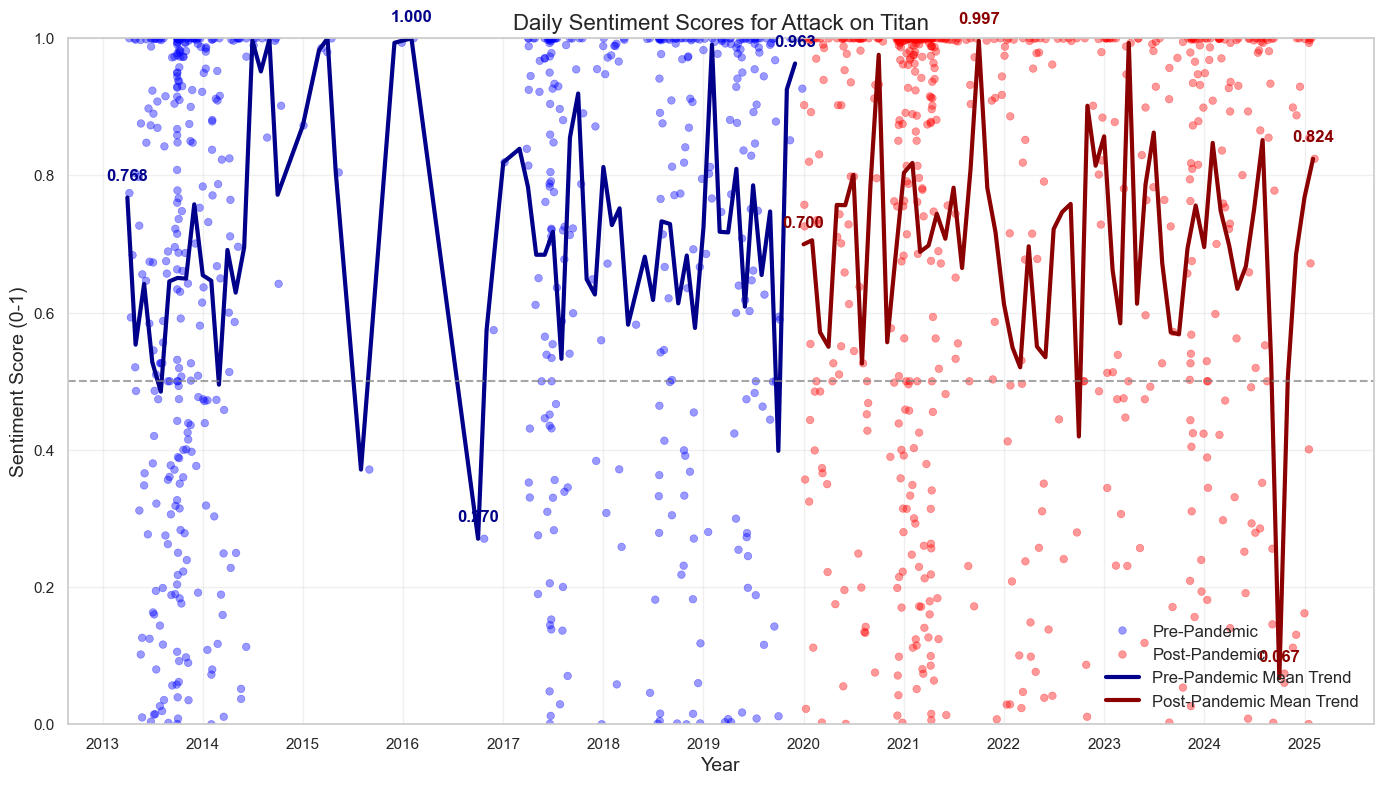

Created scatter plot for Attack on Titan: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/sentiment_scatter_Attack on Titan.png

Mean sentiment by month for Daily Sentiment Scores for Nezha (first 5 rows):
  year_month        period  sentiment_score
0    2019-07  Pre-Pandemic         0.830646
1    2019-08  Pre-Pandemic         0.735897
2    2019-09  Pre-Pandemic         0.801363
3    2019-10  Pre-Pandemic         0.641398
4    2019-11  Pre-Pandemic         0.629777


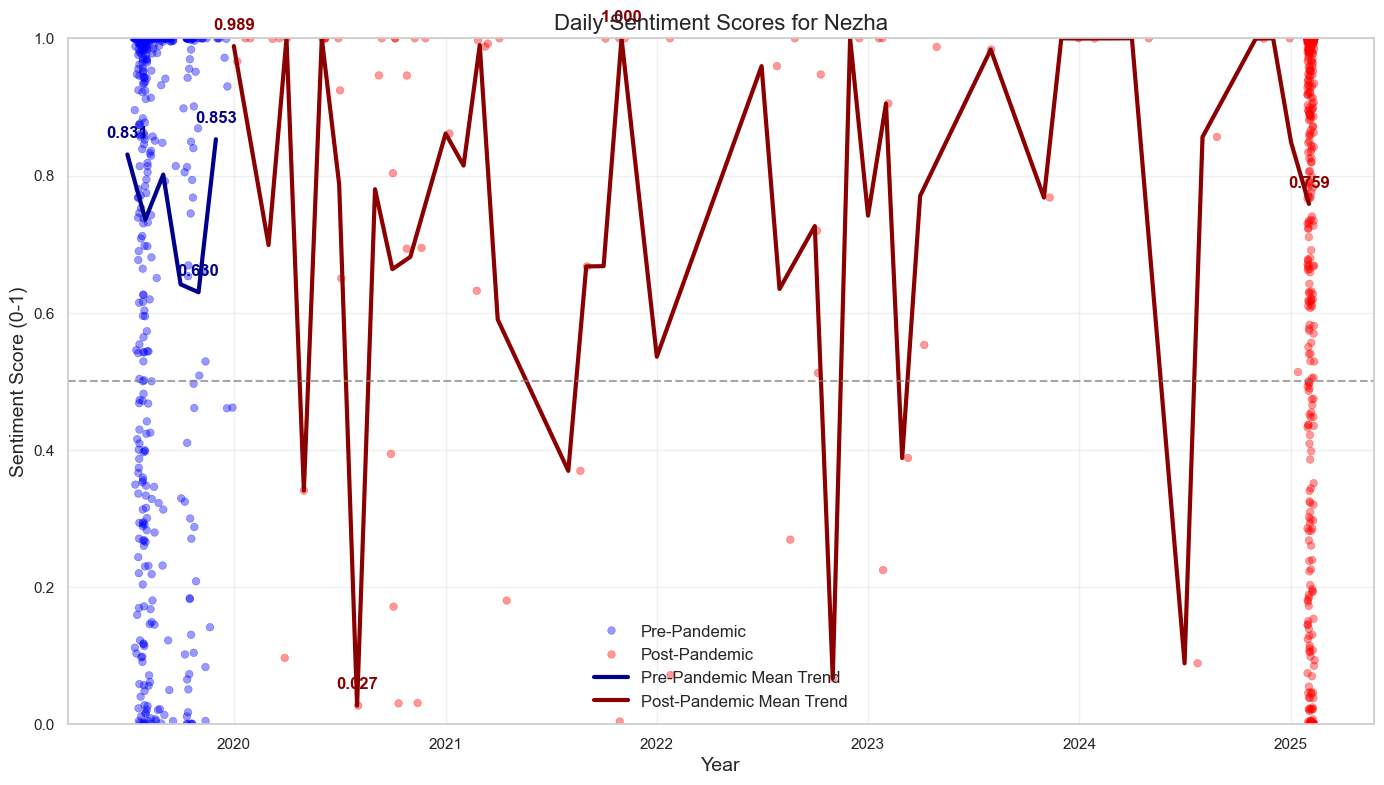

Created scatter plot for Nezha: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/sentiment_scatter_Nezha.png

Mean sentiment by month for Daily Sentiment Scores for FF7 (first 5 rows):
  year_month        period  sentiment_score
0    2005-09  Pre-Pandemic         0.500000
1    2005-10  Pre-Pandemic         0.986274
2    2005-12  Pre-Pandemic         0.700378
3    2006-01  Pre-Pandemic         0.954360
4    2006-02  Pre-Pandemic         0.761538


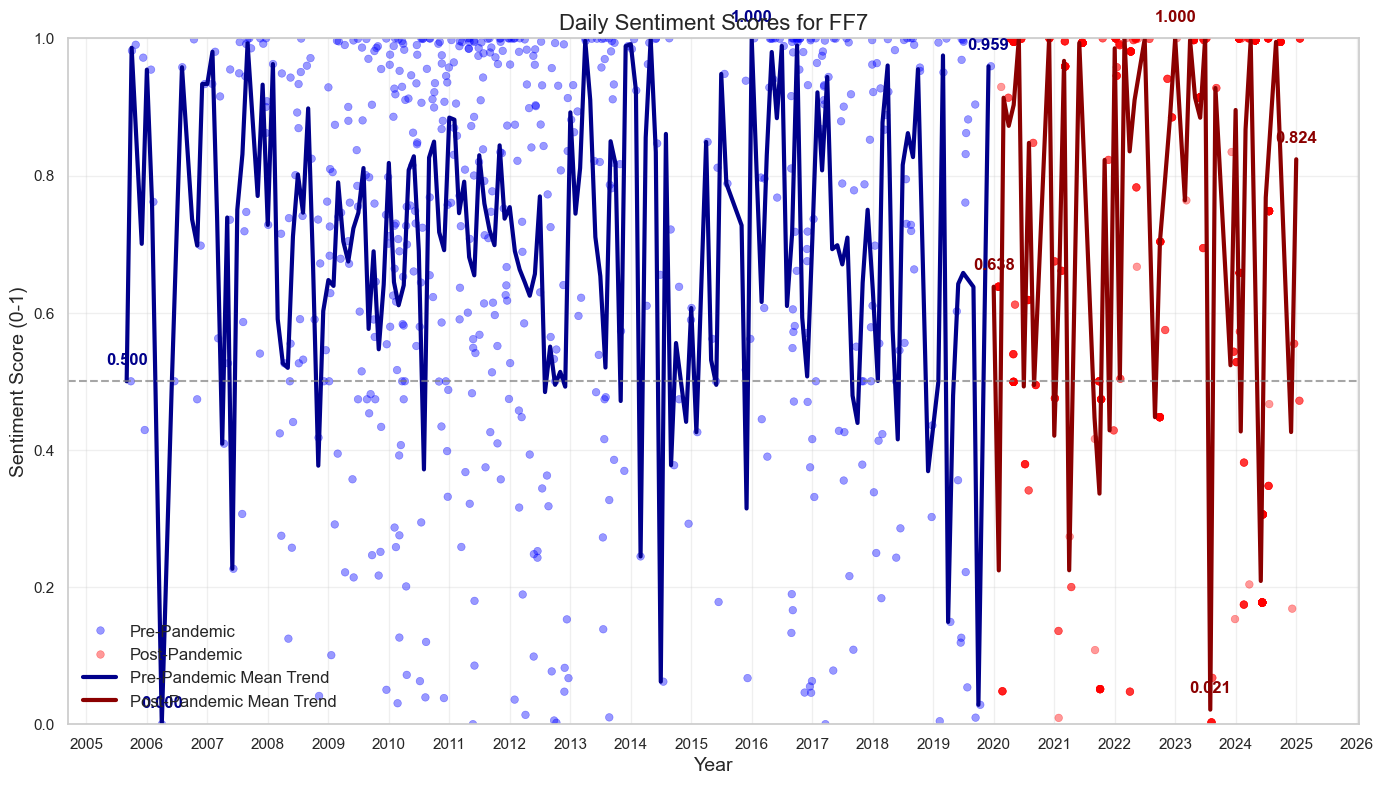

Created scatter plot for FF7: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/sentiment_scatter_FF7.png

Overall mean sentiment by month (first 5 rows):
  year_month        period  sentiment_score
0    2005-09  Pre-Pandemic         0.500000
1    2005-10  Pre-Pandemic         0.986274
2    2005-12  Pre-Pandemic         0.700378
3    2006-01  Pre-Pandemic         0.954360
4    2006-02  Pre-Pandemic         0.761538


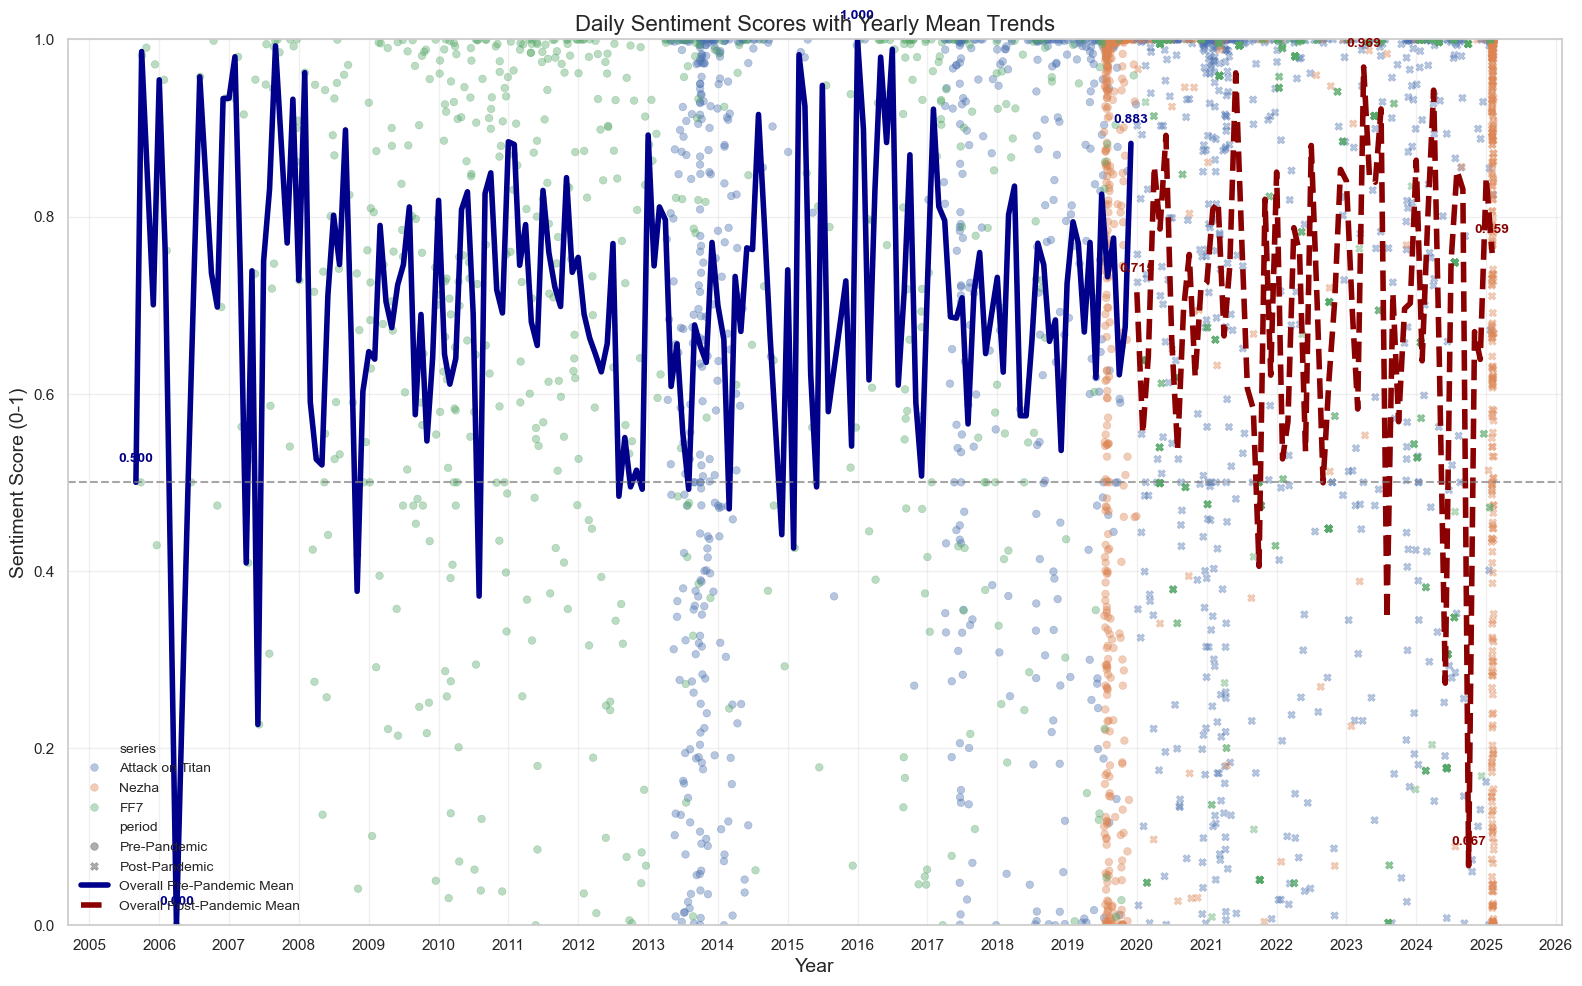

Created combined scatter plot: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/sentiment_by_year_all_series.png

Pre vs Post Pandemic Mean Sentiment Comparison:
period           Post-Pandemic  Pre-Pandemic    Change
series                                                
Attack on Titan       0.713099      0.673183  0.039917
FF7                   0.756384      0.700084  0.056300
Nezha                 0.786042      0.784218  0.001824


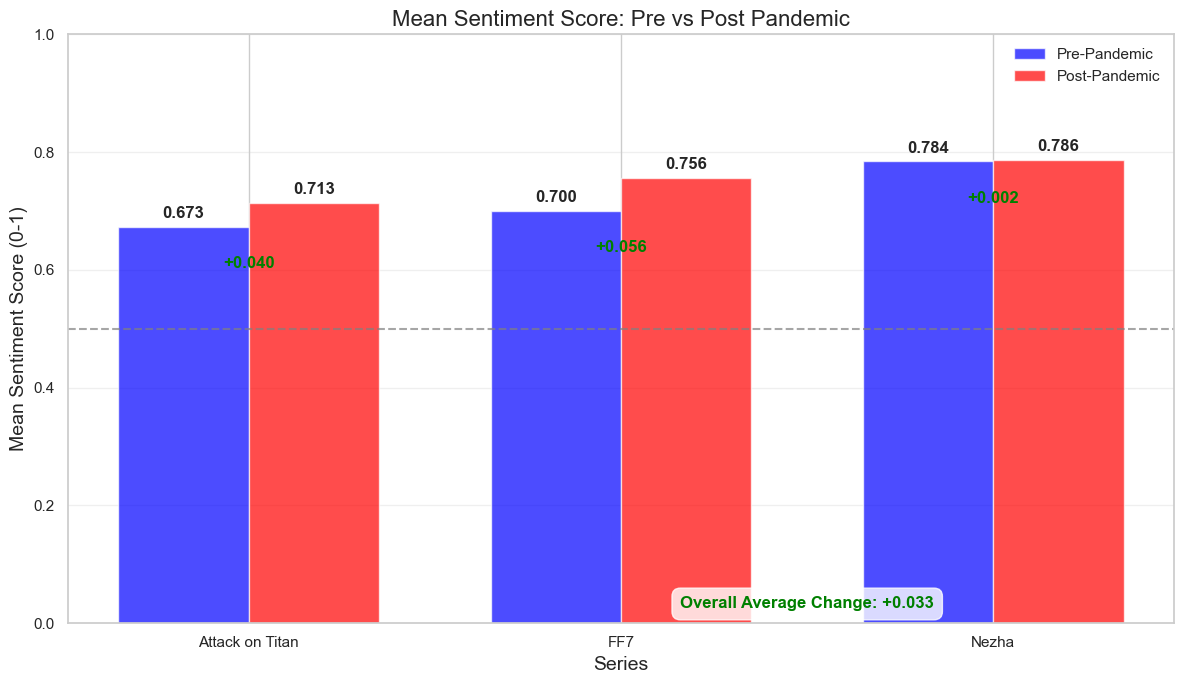

Created pandemic comparison plot: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/pre_post_pandemic_comparison.png
Summary statistics saved to: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots/sentiment_summary_by_month.csv
All visualizations complete!


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import os
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set the plot style for better aesthetics
sns.set(style="whitegrid")

"""
 * @description Load the sentiment data file and prepare it for visualization with daily data
 * @param {string} file_path - Path to the sentiment data CSV
 * @returns {DataFrame} Processed dataframe with daily timestamps
 """
def load_and_prepare_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    print(f"Loaded data with {len(df)} records")
    
    # Check available columns
    print("Available columns:", df.columns.tolist())
    
    # Try to find time column
    time_column = None
    for possible_col in ['time', 'date', 'timestamp', 'review_date']:
        if possible_col in df.columns:
            time_column = possible_col
            break
    
    # Extract date information from time column if available
    if time_column:
        print(f"Found time column: {time_column}")
        # Convert to datetime format
        df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
        
        # Use the full date for plotting (daily granularity)
        df['plot_date'] = df[time_column]
        
        # Extract year, month, day for potential grouping
        df['year'] = df[time_column].dt.year
        df['month'] = df[time_column].dt.month
        df['day'] = df[time_column].dt.day
        
        # For monthly aggregation
        df['year_month'] = df[time_column].dt.to_period('M')
        
        # Remove rows with invalid dates
        valid_dates_count = df['year'].notna().sum()
        print(f"Records with valid dates: {valid_dates_count} ({valid_dates_count/len(df)*100:.1f}%)")
        df = df.dropna(subset=['year'])
        df['year'] = df['year'].astype(int)
    else:
        # If no time column, use period as proxy
        print("No time column found. Using pandemic period as proxy.")
        df['year'] = df['period'].map({
            'Pre-Pandemic': 2019,
            'Post-Pandemic': 2020
        })
        df['month'] = df['period'].map({
            'Pre-Pandemic': 6,
            'Post-Pandemic': 6
        })
        df['day'] = 15  # Middle of the month as a default
        df['plot_date'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                                        df['month'].astype(str) + '-' + 
                                        df['day'].astype(str))
        df['year_month'] = df['plot_date'].dt.to_period('M')
    
    # Summary of date distribution
    print("Year distribution:")
    year_counts = df['year'].value_counts().sort_index()
    print(year_counts.to_string())
    
    return df

"""
 * @description Create scatter plot with daily points but yearly x-axis
 * @param {DataFrame} data - Input dataframe
 * @param {string} title - Plot title
 * @param {string} output_path - Path to save the plot
 """
def create_sentiment_scatter(data, title, output_path):
    plt.figure(figsize=(14, 8))
    
    # Create scatter plot with daily points
    scatter = sns.scatterplot(
        data=data,
        x='plot_date',
        y='sentiment_score',
        hue='period',
        palette={'Pre-Pandemic': 'blue', 'Post-Pandemic': 'red'},
        alpha=0.4,  # Lower alpha for better visibility with many points
        s=30,       # Smaller point size for daily data
        edgecolor=None  # Remove edge for cleaner look with many points
    )
    
    # Set x-axis to display only years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    # Calculate monthly mean for trend lines (daily would be too noisy)
    means_by_month = data.groupby(['year_month', 'period'])['sentiment_score'].mean().reset_index()
    means_by_month['plot_date'] = means_by_month['year_month'].dt.to_timestamp()
    
    # Sort by date to ensure correct line connectivity
    means_by_month = means_by_month.sort_values('plot_date')
    
    print(f"\nMean sentiment by month for {title} (first 5 rows):")
    print(means_by_month[['year_month', 'period', 'sentiment_score']].head())
    
    # Add mean trend lines for each period
    for period, color in zip(['Pre-Pandemic', 'Post-Pandemic'], ['darkblue', 'darkred']):
        period_means = means_by_month[means_by_month['period'] == period]
        if len(period_means) > 1:
            # Plot the mean line
            plt.plot(period_means['plot_date'], period_means['sentiment_score'], 
                     '-',  # Just a line without markers for cleaner look
                     color=color, 
                     linewidth=3,
                     label=f'{period} Mean Trend')
            
            # Add text labels to important points
            # Start and end points
            for idx in [0, -1]:
                row = period_means.iloc[idx]
                plt.text(row['plot_date'], row['sentiment_score'] + 0.02, 
                        f"{row['sentiment_score']:.3f}", 
                        ha='center', va='bottom',
                        color=color, fontweight='bold')
            
            # Add labels to highest and lowest points if they're not already labeled
            if len(period_means) > 2:
                max_idx = period_means['sentiment_score'].idxmax()
                min_idx = period_means['sentiment_score'].idxmin()
                
                for idx in [max_idx, min_idx]:
                    if idx != period_means.index[0] and idx != period_means.index[-1]:
                        row = period_means.loc[idx]
                        plt.text(row['plot_date'], row['sentiment_score'] + 0.02, 
                                f"{row['sentiment_score']:.3f}", 
                                ha='center', va='bottom',
                                color=color, fontweight='bold')
    
    # Customize plot appearance
    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Sentiment Score (0-1)', fontsize=14)
    plt.ylim(0, 1)
    
    # Add explanatory elements
    plt.grid(True, alpha=0.3)
    plt.legend(title='', fontsize=12, loc='best')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Neutral sentiment line
    
    # Save and display the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()  # Close to free memory

"""
 * @description Create a combined scatter plot with only overall mean trend lines
 * @param {DataFrame} df - Input dataframe
 * @param {string} output_dir - Directory to save plots
 """
def create_combined_scatter(df, output_dir):
    plt.figure(figsize=(16, 10))
    
    # Use different markers for different periods
    sns.scatterplot(
        data=df,
        x='plot_date',
        y='sentiment_score',
        hue='series',  # Color by series
        style='period', # Different marker styles for periods
        alpha=0.4,
        s=30,
        edgecolor=None
    )
    
    # Set x-axis to display only years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    # Calculate monthly means for trend lines (using daily would be too noisy)
    overall_means = df.groupby(['year_month', 'period'])['sentiment_score'].mean().reset_index()
    overall_means['plot_date'] = overall_means['year_month'].dt.to_timestamp()
    overall_means = overall_means.sort_values('plot_date')
    
    print("\nOverall mean sentiment by month (first 5 rows):")
    print(overall_means[['year_month', 'period', 'sentiment_score']].head())
    
    # Plot overall trend lines for pre and post pandemic
    for period, color, linestyle in zip(['Pre-Pandemic', 'Post-Pandemic'], ['darkblue', 'darkred'], ['-', '--']):
        period_means = overall_means[overall_means['period'] == period]
        if len(period_means) > 1:
            plt.plot(period_means['plot_date'], period_means['sentiment_score'],
                    '-',
                    color=color,
                    linestyle=linestyle,
                    linewidth=4,
                    label=f'Overall {period} Mean')
            
            # Add labels to important points
            for idx in [0, -1]:  # First and last points
                row = period_means.iloc[idx]
                plt.text(row['plot_date'], row['sentiment_score'] + 0.02, 
                         f"{row['sentiment_score']:.3f}", 
                         ha='center', va='bottom',
                         color=color, fontweight='bold', fontsize=10)
            
            # Label extremes if not already labeled
            if len(period_means) > 2:
                max_idx = period_means['sentiment_score'].idxmax()
                min_idx = period_means['sentiment_score'].idxmin()
                
                for idx in [max_idx, min_idx]:
                    if idx != period_means.index[0] and idx != period_means.index[-1]:
                        row = period_means.loc[idx]
                        plt.text(row['plot_date'], row['sentiment_score'] + 0.02, 
                                f"{row['sentiment_score']:.3f}", 
                                ha='center', va='bottom',
                                color=color, fontweight='bold', fontsize=10)
    
    # Customize plot
    plt.title('Daily Sentiment Scores with Yearly Mean Trends', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Sentiment Score (0-1)', fontsize=14)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(title='', fontsize=10, loc='best')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Neutral sentiment line
    
    # Save and display
    output_path = os.path.join(output_dir, 'sentiment_by_year_all_series.png')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Created combined scatter plot: {output_path}")

"""
 * @description Create a direct comparison of pre vs post pandemic mean sentiment
 * @param {DataFrame} df - Input dataframe
 * @param {string} output_dir - Directory to save plot
 """
def create_pandemic_comparison_plot(df, output_dir):
    # Calculate mean sentiment for each series and period
    comparison_data = df.groupby(['series', 'period'])['sentiment_score'].mean().reset_index()
    
    # Pivot for easier plotting
    comparison_pivot = comparison_data.pivot(index='series', columns='period', values='sentiment_score')
    comparison_pivot['Change'] = comparison_pivot['Post-Pandemic'] - comparison_pivot['Pre-Pandemic']
    
    # Print the comparison table
    print("\nPre vs Post Pandemic Mean Sentiment Comparison:")
    print(comparison_pivot)
    
    # Plot the comparison
    plt.figure(figsize=(12, 7))
    
    # Create a bar chart
    x = np.arange(len(comparison_pivot.index))
    width = 0.35
    
    plt.bar(x - width/2, comparison_pivot['Pre-Pandemic'], width, label='Pre-Pandemic',
           color='blue', alpha=0.7)
    plt.bar(x + width/2, comparison_pivot['Post-Pandemic'], width, label='Post-Pandemic',
           color='red', alpha=0.7)
    
    # Add value labels on bars
    for i, v in enumerate(comparison_pivot['Pre-Pandemic']):
        plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
    
    for i, v in enumerate(comparison_pivot['Post-Pandemic']):
        plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
        
    # Add change values between bars
    for i, v in enumerate(comparison_pivot['Change']):
        color = 'green' if v > 0 else 'red'
        plt.text(i, min(comparison_pivot['Pre-Pandemic'][i], comparison_pivot['Post-Pandemic'][i]) - 0.05,
                f"{v:+.3f}", ha='center', va='top', color=color, fontweight='bold')
    
    # Overall average change
    overall_pre = comparison_pivot['Pre-Pandemic'].mean()
    overall_post = comparison_pivot['Post-Pandemic'].mean()
    overall_change = overall_post - overall_pre
    
    # Add overall average at the bottom of the chart
    plt.text(len(comparison_pivot.index)/2, 0.02, 
             f"Overall Average Change: {overall_change:+.3f}",
             ha='center', va='bottom', 
             color='green' if overall_change > 0 else 'red',
             fontweight='bold', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Customize plot
    plt.title('Mean Sentiment Score: Pre vs Post Pandemic', fontsize=16)
    plt.xlabel('Series', fontsize=14)
    plt.ylabel('Mean Sentiment Score (0-1)', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(x, comparison_pivot.index)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Save and display
    output_path = os.path.join(output_dir, 'pre_post_pandemic_comparison.png')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Created pandemic comparison plot: {output_path}")

# Main execution code
# File path for the sentiment data
file_path = '/Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv'
base_dir = os.path.dirname(file_path)

# Create output directory for plots
output_dir = os.path.join(base_dir, 'sentiment_plots')
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# Load and prepare the data
df = load_and_prepare_data(file_path)

# Create scatter plots for each series
unique_series = df['series'].unique()
for series_name in unique_series:
    series_data = df[df['series'] == series_name]
    
    # Skip if insufficient data
    if len(series_data) < 10:
        print(f"Skipping {series_name} due to insufficient data points")
        continue
    
    # Create plot title and output path
    title = f'Daily Sentiment Scores for {series_name}'
    output_path = os.path.join(output_dir, f'sentiment_scatter_{series_name}.png')
    
    # Create scatter plot
    create_sentiment_scatter(series_data, title, output_path)
    print(f"Created scatter plot for {series_name}: {output_path}")

# Create a combined scatter plot for all series with only overall mean lines
create_combined_scatter(df, output_dir)

# Create a direct comparison of pre vs post pandemic means
create_pandemic_comparison_plot(df, output_dir)

# Create daily summary statistics (aggregated by month for readability)
summary = df.groupby(['year_month', 'period'])['sentiment_score'].agg(
    mean='mean',
    median='median',
    std='std',
    count='count'
).reset_index()

# Save summary statistics
summary_path = os.path.join(output_dir, 'sentiment_summary_by_month.csv')
summary.to_csv(summary_path, index=False)
print(f"Summary statistics saved to: {summary_path}")

print("All visualizations complete!")

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set the plot style for better aesthetics
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'  # A widely available font
plt.rcParams['font.size'] = 10  # Set default font size

"""
 * @description Load the sentiment data file and prepare it for visualization
 * @param {string} file_path - Path to the sentiment data CSV
 * @returns {DataFrame} Processed dataframe with timestamps
 """
def load_and_prepare_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    print(f"Loaded data with {len(df)} records")
    
    # Check available columns
    print("Available columns:", df.columns.tolist())
    
    # Try to find time column
    time_column = None
    for possible_col in ['time', 'date', 'timestamp', 'review_date']:
        if possible_col in df.columns:
            time_column = possible_col
            break
    
    # Extract date information from time column if available
    if time_column:
        print(f"Found time column: {time_column}")
        # Convert to datetime format
        df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
        
        # Use the full date for plotting (daily granularity)
        df['plot_date'] = df[time_column]
        
        # Extract year, month, day for potential grouping
        df['year'] = df[time_column].dt.year
        df['month'] = df[time_column].dt.month
        df['day'] = df[time_column].dt.day
        
        # For monthly aggregation
        df['year_month'] = df[time_column].dt.to_period('M')
        
        # Remove rows with invalid dates
        valid_dates_count = df['year'].notna().sum()
        print(f"Records with valid dates: {valid_dates_count} ({valid_dates_count/len(df)*100:.1f}%)")
        df = df.dropna(subset=['year'])
        df['year'] = df['year'].astype(int)
    else:
        # If no time column, use period as proxy
        print("No time column found. Using pandemic period as proxy.")
        df['year'] = df['period'].map({
            'Pre-Pandemic': 2019,
            'Post-Pandemic': 2020
        })
        df['month'] = df['period'].map({
            'Pre-Pandemic': 6,
            'Post-Pandemic': 6
        })
        df['day'] = 15  # Middle of the month as a default
        df['plot_date'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                                        df['month'].astype(str) + '-' + 
                                        df['day'].astype(str))
        df['year_month'] = df['plot_date'].dt.to_period('M')
    
    # Summary of date distribution
    print("Year distribution:")
    year_counts = df['year'].value_counts().sort_index()
    print(year_counts.to_string())
    
    return df

"""
 * @description Test data normality and choose appropriate statistical test
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @param {string} output_dir - Directory to save plots
 * @returns {dict} Results of normality and statistical tests
 """
def analyze_data_normality(df, output_dir):
    plt.figure(figsize=(16, 12))
    
    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Histogram of all sentiment scores
    ax1 = axes[0, 0]
    sns.histplot(data=df, x='sentiment_score', hue='period', kde=True, ax=ax1)
    ax1.set_title('Histogram of Sentiment Scores', fontsize=14)
    ax1.set_xlabel('Sentiment Score')
    ax1.set_ylabel('Frequency')
    
    # 2. QQ plot for Pre-Pandemic
    ax2 = axes[0, 1]
    pre_scores = df[df['period'] == 'Pre-Pandemic']['sentiment_score']
    stats.probplot(pre_scores, dist="norm", plot=ax2)
    ax2.set_title('QQ Plot for Pre-Pandemic Scores', fontsize=14)
    
    # 3. QQ plot for Post-Pandemic
    ax3 = axes[1, 0]
    post_scores = df[df['period'] == 'Post-Pandemic']['sentiment_score']
    stats.probplot(post_scores, dist="norm", plot=ax3)
    ax3.set_title('QQ Plot for Post-Pandemic Scores', fontsize=14)
    
    # 4. Box plot comparison
    ax4 = axes[1, 1]
    sns.boxplot(data=df, x='period', y='sentiment_score', ax=ax4)
    ax4.set_title('Box Plot Comparison', fontsize=14)
    ax4.set_xlabel('Period')
    ax4.set_ylabel('Sentiment Score')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'normality_tests.png'), dpi=300)
    plt.close()
    
    # Perform Shapiro-Wilk test for normality
    print("\n=== Normality Tests ===")
    
    # Overall tests
    print("\nPre-Pandemic Scores:")
    # For large samples, sample a subset for Shapiro-Wilk test
    pre_sample = pre_scores.sample(min(5000, len(pre_scores)), random_state=42)
    sw_stat_pre, p_value_pre = stats.shapiro(pre_sample)
    print(f"Shapiro-Wilk Test: statistic={sw_stat_pre:.4f}, p-value={p_value_pre:.8f}")
    print(f"Normal distribution: {'Rejected' if p_value_pre < 0.05 else 'Not rejected'} (α=0.05)")
    
    # Also perform D'Agostino-Pearson test which works better for large samples
    dp_stat_pre, dp_p_value_pre = stats.normaltest(pre_scores)
    print(f"D'Agostino-Pearson Test: statistic={dp_stat_pre:.4f}, p-value={dp_p_value_pre:.8f}")
    print(f"Normal distribution: {'Rejected' if dp_p_value_pre < 0.05 else 'Not rejected'} (α=0.05)")
    
    print("\nPost-Pandemic Scores:")
    post_sample = post_scores.sample(min(5000, len(post_scores)), random_state=42)
    sw_stat_post, p_value_post = stats.shapiro(post_sample)
    print(f"Shapiro-Wilk Test: statistic={sw_stat_post:.4f}, p-value={p_value_post:.8f}")
    print(f"Normal distribution: {'Rejected' if p_value_post < 0.05 else 'Not rejected'} (α=0.05)")
    
    dp_stat_post, dp_p_value_post = stats.normaltest(post_scores)
    print(f"D'Agostino-Pearson Test: statistic={dp_stat_post:.4f}, p-value={dp_p_value_post:.8f}")
    print(f"Normal distribution: {'Rejected' if dp_p_value_post < 0.05 else 'Not rejected'} (α=0.05)")
    
    # Additional descriptive statistics
    print("\n=== Descriptive Statistics ===")
    print("\nPre-Pandemic:")
    print(f"Mean: {pre_scores.mean():.4f}")
    print(f"Median: {pre_scores.median():.4f}")
    print(f"Skewness: {stats.skew(pre_scores):.4f}")
    print(f"Kurtosis: {stats.kurtosis(pre_scores):.4f}")
    
    print("\nPost-Pandemic:")
    print(f"Mean: {post_scores.mean():.4f}")
    print(f"Median: {post_scores.median():.4f}")
    print(f"Skewness: {stats.skew(post_scores):.4f}")
    print(f"Kurtosis: {stats.kurtosis(post_scores):.4f}")
    
    # Check if both distributions are non-normal
    is_non_normal = (p_value_pre < 0.05 or p_value_post < 0.05)
    
    # Perform series-specific tests to see if any series have normal distributions
    print("\n=== Series-Specific Normality Tests ===")
    series_normality = {}
    
    for series_name in df['series'].unique():
        series_pre = df[(df['series'] == series_name) & (df['period'] == 'Pre-Pandemic')]['sentiment_score']
        series_post = df[(df['series'] == series_name) & (df['period'] == 'Post-Pandemic')]['sentiment_score']
        
        if len(series_pre) > 3 and len(series_post) > 3:  # Need at least a few samples
            # Sample if too large
            series_pre_sample = series_pre.sample(min(5000, len(series_pre)), random_state=42)
            series_post_sample = series_post.sample(min(5000, len(series_post)), random_state=42)
            
            try:
                _, series_p_pre = stats.shapiro(series_pre_sample)
                _, series_p_post = stats.shapiro(series_post_sample)
                
                series_normality[series_name] = {
                    'pre_normal': series_p_pre >= 0.05,
                    'post_normal': series_p_post >= 0.05,
                    'both_normal': series_p_pre >= 0.05 and series_p_post >= 0.05
                }
                
                print(f"\n{series_name}:")
                print(f"Pre-Pandemic normal: {'Yes' if series_p_pre >= 0.05 else 'No'} (p={series_p_pre:.4f})")
                print(f"Post-Pandemic normal: {'Yes' if series_p_post >= 0.05 else 'No'} (p={series_p_post:.4f})")
            except:
                print(f"\n{series_name}: Insufficient data for normality test")
                series_normality[series_name] = {
                    'pre_normal': False,
                    'post_normal': False,
                    'both_normal': False
                }
    
    # Compare with non-parametric test
    print("\n=== Parametric vs. Non-parametric Tests ===")
    
    # T-test (parametric)
    t_stat, t_p = stats.ttest_ind(pre_scores, post_scores, equal_var=False)
    print(f"Welch's t-test: t={t_stat:.4f}, p-value={t_p:.8f}")
    print(f"Significant difference (α=0.05): {'Yes' if t_p < 0.05 else 'No'}")
    
    # Mann-Whitney U test (non-parametric)
    u_stat, u_p = stats.mannwhitneyu(pre_scores, post_scores, alternative='two-sided')
    print(f"Mann-Whitney U test: U={u_stat:.4f}, p-value={u_p:.8f}")
    print(f"Significant difference (α=0.05): {'Yes' if u_p < 0.05 else 'No'}")
    
    # Compare results
    results_agree = (t_p < 0.05 and u_p < 0.05) or (t_p >= 0.05 and u_p >= 0.05)
    
    # Series-specific statistical tests
    series_results = {}
    for series_name in df['series'].unique():
        series_pre = df[(df['series'] == series_name) & (df['period'] == 'Pre-Pandemic')]['sentiment_score']
        series_post = df[(df['series'] == series_name) & (df['period'] == 'Post-Pandemic')]['sentiment_score']
        
        if len(series_pre) > 3 and len(series_post) > 3:
            # T-test
            try:
                t_stat, t_p = stats.ttest_ind(series_pre, series_post, equal_var=False)
            except:
                t_stat, t_p = np.nan, np.nan
                
            # Mann-Whitney
            try:
                u_stat, u_p = stats.mannwhitneyu(series_pre, series_post, alternative='two-sided')
            except:
                u_stat, u_p = np.nan, np.nan
            
            # Check if both tests agree
            if not np.isnan(t_p) and not np.isnan(u_p):
                both_agree = (t_p < 0.05 and u_p < 0.05) or (t_p >= 0.05 and u_p >= 0.05)
            else:
                both_agree = np.nan
                
            series_results[series_name] = {
                't_test': {'statistic': t_stat, 'p': t_p, 'significant': t_p < 0.05 if not np.isnan(t_p) else np.nan},
                'mann_whitney': {'statistic': u_stat, 'p': u_p, 'significant': u_p < 0.05 if not np.isnan(u_p) else np.nan},
                'agree': both_agree
            }
    
    # Visualize statistical test comparison
    plot_df = pd.DataFrame([
        {
            'Series': series_name,
            'T-test p-value': result['t_test']['p'],
            'MW p-value': result['mann_whitney']['p'],
            'T-test Significant': result['t_test']['significant'],
            'MW Significant': result['mann_whitney']['significant'],
            'Tests Agree': result['agree']
        }
        for series_name, result in series_results.items()
        if not np.isnan(result['t_test']['p']) and not np.isnan(result['mann_whitney']['p'])
    ])
    
    plt.figure(figsize=(12, 8))
    
    # Create a bar plot to compare p-values
    ax = plt.subplot(111)
    
    x = np.arange(len(plot_df))
    width = 0.35
    
    # T-test bars
    rects1 = ax.bar(x - width/2, plot_df['T-test p-value'], width, 
                   label='T-test p-values', color='blue', alpha=0.7)
    
    # Mann-Whitney bars
    rects2 = ax.bar(x + width/2, plot_df['MW p-value'], width,
                   label='Mann-Whitney p-values', color='red', alpha=0.7)
    
    # Add significance threshold line
    ax.axhline(y=0.05, color='black', linestyle='--', alpha=0.7, label='Significance threshold (α=0.05)')
    
    # Add test agreement indicators - fixed to use direct indexing rather than _7
    for i, (idx, row) in enumerate(plot_df.iterrows()):
        if row['Tests Agree']:  # Access by column name
            ax.annotate('✓', xy=(i, 0.01), ha='center', va='center', 
                       bbox=dict(boxstyle='circle', fc='green', alpha=0.6))
        else:
            ax.annotate('≠', xy=(i, 0.01), ha='center', va='center',
                       bbox=dict(boxstyle='circle', fc='orange', alpha=0.6))
    
    # Customize plot
    ax.set_xlabel('Series', fontsize=12)
    ax.set_ylabel('p-value', fontsize=12)
    ax.set_title('Comparison of Statistical Test Results by Series', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df['Series'], rotation=45, ha='right')
    ax.legend()
    
    # Annotate p-values on bars
    for i, rect in enumerate(rects1):
        height = rect.get_height()
        ax.annotate(f"{height:.4f}",
                   xy=(rect.get_x() + rect.get_width()/2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', color='blue')
        
    for i, rect in enumerate(rects2):
        height = rect.get_height()
        ax.annotate(f"{height:.4f}",
                   xy=(rect.get_x() + rect.get_width()/2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', color='red')
    
    # Add legend for agreement
    agreement_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Tests agree'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Tests disagree')
    ]
    second_legend = plt.legend(handles=agreement_elements, loc='upper right')
    ax.add_artist(second_legend)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'test_comparison.png'), dpi=300)
    plt.close()
    
    print("\n=== Conclusion ===")
    if is_non_normal:
        print("The data does not follow a normal distribution.")
        print("It is recommended to use the non-parametric Mann-Whitney U test.")
        if results_agree:
            print("However, both tests lead to the same conclusion in this case.")
            if t_p < 0.05:
                print("Both tests indicate a significant difference between pre and post pandemic scores.")
            else:
                print("Both tests indicate no significant difference between pre and post pandemic scores.")
        else:
            print("The two tests lead to different conclusions.")
            print("Since the normality assumption is violated, the Mann-Whitney U test result is more reliable.")
    else:
        print("The data appears to follow a normal distribution.")
        print("The t-test is appropriate for this data.")
    
    # Return test results for further analysis
    return {
        'is_normal': not is_non_normal,
        't_test': {'statistic': t_stat, 'p_value': t_p},
        'mann_whitney': {'statistic': u_stat, 'p_value': u_p},
        'results_agree': results_agree,
        'series_normality': series_normality,
        'series_results': series_results
    }

"""
 * @description Create boxplot with appropriate statistical tests
 * @param {DataFrame} df - Input dataframe
 * @param {dict} normality_results - Results from normality testing
 * @param {string} output_dir - Directory to save plot
 """
def create_boxplot_with_appropriate_tests(df, normality_results, output_dir):
    plt.figure(figsize=(14, 8))
    
    # Create boxplot with series on x-axis and period as hue
    boxplot = sns.boxplot(
        data=df,
        x='series', 
        y='sentiment_score',
        hue='period',
        palette={'Pre-Pandemic': 'blue', 'Post-Pandemic': 'red'},
        width=0.7,
        fliersize=3  # Smaller outlier points
    )
    
    # Add statistical annotations
    for i, series_name in enumerate(df['series'].unique()):
        # Check if series exists in results
        if series_name not in normality_results['series_results']:
            continue
            
        result = normality_results['series_results'][series_name]
        
        # Skip if insufficient data
        if np.isnan(result['t_test']['p']) and np.isnan(result['mann_whitney']['p']):
            continue
            
        # Determine which test to use based on normality
        is_normal = normality_results['series_normality'].get(series_name, {}).get('both_normal', False)
        
        if is_normal:
            p_value = result['t_test']['p']
            test_name = 't'
        else:
            p_value = result['mann_whitney']['p']
            test_name = 'MW'
            
        # Skip if missing p-value
        if np.isnan(p_value):
            continue
        
        # Add significance stars
        if p_value < 0.001:
            sig_text = '***'
        elif p_value < 0.01:
            sig_text = '**'
        elif p_value < 0.05:
            sig_text = '*'
        else:
            sig_text = 'ns'
            
        # Find the series data for positioning
        series_data = df[df['series'] == series_name]
        max_y = series_data['sentiment_score'].max() + 0.03
        
        # Add significance annotation with test name
        plt.text(i, max_y, f"{sig_text}\n({test_name})", ha='center', va='bottom', fontweight='bold')
        
        # Add a line connecting the boxes
        x1 = i - 0.2  # Approximate x position of first box
        x2 = i + 0.2  # Approximate x position of second box
        line_y = max_y - 0.02
        plt.plot([x1, x2], [line_y, line_y], 'k-')
    
    # Add a legend for significance
    legend_elements = [
        plt.Line2D([0], [0], marker='', color='white', label='Significance:'),
        plt.Line2D([0], [0], marker='', color='white', label='*** p<0.001'),
        plt.Line2D([0], [0], marker='', color='white', label='** p<0.01'),
        plt.Line2D([0], [0], marker='', color='white', label='* p<0.05'),
        plt.Line2D([0], [0], marker='', color='white', label='ns p≥0.05'),
        plt.Line2D([0], [0], marker='', color='white', label='(t) t-test'),
        plt.Line2D([0], [0], marker='', color='white', label='(MW) Mann-Whitney')
    ]
    
    # Add the second legend for significance
    first_legend = plt.legend(title='Period', loc='upper left')
    plt.gca().add_artist(first_legend)
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Customize plot
    plt.title('Sentiment Score Distribution with Appropriate Tests', fontsize=16)
    plt.xlabel('Series', fontsize=14)
    plt.ylabel('Sentiment Score (0-1)', fontsize=14)
    plt.ylim(0, 1.05)  # Slightly increased to accommodate significance markers
    plt.grid(True, axis='y', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Neutral sentiment line
    
    # Add overall statistics as text annotation
    overall_pre = df[df['period'] == 'Pre-Pandemic']['sentiment_score']
    overall_post = df[df['period'] == 'Post-Pandemic']['sentiment_score']
    
    # Select appropriate test based on overall normality
    if normality_results['is_normal']:
        overall_stat = normality_results['t_test']['statistic']
        overall_p = normality_results['t_test']['p_value']
        test_type = "t-test"
    else:
        overall_stat = normality_results['mann_whitney']['statistic']
        overall_p = normality_results['mann_whitney']['p_value']
        test_type = "Mann-Whitney"
    
    stats_text = (
        f"Overall Statistics:\n"
        f"Pre-Pandemic: mean={overall_pre.mean():.3f}, median={overall_pre.median():.3f}\n"
        f"Post-Pandemic: mean={overall_post.mean():.3f}, median={overall_post.median():.3f}\n"
        f"{test_type}: {'statistic' if test_type=='Mann-Whitney' else 't'}={overall_stat:.2f}, p={overall_p:.4f}"
    )
    
    plt.annotate(
        stats_text, xy=(0.02, 0.02), xycoords='figure fraction',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
        fontsize=10
    )
    
    # Save and display
    output_path = os.path.join(output_dir, 'boxplot_with_appropriate_tests.png')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Created boxplot with appropriate tests: {output_path}")

"""
 * @description Create a pandemic comparison bar chart with appropriate statistical tests
 * @param {DataFrame} df - Input dataframe
 * @param {dict} normality_results - Results from normality testing 
 * @param {string} output_dir - Directory to save plot
 """
def create_pandemic_comparison_with_appropriate_tests(df, normality_results, output_dir):
    # Calculate mean sentiment for each series and period
    comparison_data = df.groupby(['series', 'period'])['sentiment_score'].mean().reset_index()
    
    # Pivot for easier plotting
    comparison_pivot = comparison_data.pivot(index='series', columns='period', values='sentiment_score')
    comparison_pivot['Change'] = comparison_pivot['Post-Pandemic'] - comparison_pivot['Pre-Pandemic']
    
    # Add statistical significance info
    comparison_pivot['p_value'] = np.nan
    comparison_pivot['significant'] = False
    comparison_pivot['test_used'] = ''
    
    for series_name in comparison_pivot.index:
        if series_name in normality_results['series_results']:
            result = normality_results['series_results'][series_name]
            is_normal = normality_results['series_normality'].get(series_name, {}).get('both_normal', False)
            
            if is_normal:
                # Use t-test results
                comparison_pivot.loc[series_name, 'p_value'] = result['t_test']['p']
                comparison_pivot.loc[series_name, 'test_used'] = 't-test'
            else:
                # Use Mann-Whitney results
                comparison_pivot.loc[series_name, 'p_value'] = result['mann_whitney']['p']
                comparison_pivot.loc[series_name, 'test_used'] = 'Mann-Whitney'
                
            comparison_pivot.loc[series_name, 'significant'] = comparison_pivot.loc[series_name, 'p_value'] < 0.05
    
    # Print the comparison table
    print("\nPre vs Post Pandemic Mean Sentiment Comparison with Statistical Tests:")
    print(comparison_pivot)
    
    # Plot the comparison
    plt.figure(figsize=(14, 8))
    
    # Create a bar chart
    x = np.arange(len(comparison_pivot.index))
    width = 0.35
    
    # Sort by change magnitude
    sorted_pivot = comparison_pivot.sort_values('Change')
    
    # Create bars
    plt.bar(x - width/2, sorted_pivot['Pre-Pandemic'], width, label='Pre-Pandemic',
           color='blue', alpha=0.7)
    plt.bar(x + width/2, sorted_pivot['Post-Pandemic'], width, label='Post-Pandemic',
           color='red', alpha=0.7)
    
    # Add value labels on bars
    for i, v in enumerate(sorted_pivot['Pre-Pandemic']):
        plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
    
    for i, v in enumerate(sorted_pivot['Post-Pandemic']):
        plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')
        
    # Add change values between bars with significance markers
    for i, (idx, row) in enumerate(sorted_pivot.iterrows()):
        change = row['Change']
        color = 'green' if change > 0 else 'red'
        
        # Create significance marker
        if pd.notna(row['p_value']):
            if row['p_value'] < 0.001:
                sig_marker = '***'
            elif row['p_value'] < 0.01:
                sig_marker = '**'
            elif row['p_value'] < 0.05:
                sig_marker = '*'
            else:
                sig_marker = 'ns'
                
            change_text = f"{change:+.3f} {sig_marker}"
        else:
            change_text = f"{change:+.3f}"
            
        plt.text(i, min(row['Pre-Pandemic'], row['Post-Pandemic']) - 0.05,
                change_text, ha='center', va='top', color=color, fontweight='bold')
    
    # Overall average change
    overall_pre = df[df['period'] == 'Pre-Pandemic']['sentiment_score'].mean()
    overall_post = df[df['period'] == 'Post-Pandemic']['sentiment_score'].mean()
    overall_change = overall_post - overall_pre
    
    # Calculate overall p-value using appropriate test
    if normality_results['is_normal']:
        overall_p = normality_results['t_test']['p_value']
        test_name = 't-test'
    else:
        overall_p = normality_results['mann_whitney']['p_value']
        test_name = 'Mann-Whitney'
    
    # Add overall average at the bottom of the chart
    if overall_p < 0.001:
        sig_text = '***'
    elif overall_p < 0.01:
        sig_text = '**'
    elif overall_p < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
        
    plt.text(len(comparison_pivot.index)/2, 0.02, 
             f"Overall Average Change: {overall_change:+.3f} {sig_text}\n({test_name}, p={overall_p:.4f})",
             ha='center', va='bottom', 
             color='green' if overall_change > 0 else 'red',
             fontweight='bold', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add a legend for significance
    legend_elements = plt.legend().get_lines()
    legend_elements.extend([
        plt.Line2D([0], [0], marker='', color='white', label=''),
        plt.Line2D([0], [0], marker='', color='white', label='Significance:'),
        plt.Line2D([0], [0], marker='', color='white', label='*** p<0.001'),
        plt.Line2D([0], [0], marker='', color='white', label='** p<0.01'),
        plt.Line2D([0], [0], marker='', color='white', label='* p<0.05'),
        plt.Line2D([0], [0], marker='', color='white', label='ns = not significant')
    ])
    
    # Customize plot
    plt.title('Mean Sentiment Score: Pre vs Post Pandemic (with Statistical Significance)', fontsize=16)
    plt.xlabel('Series', fontsize=14)
    plt.ylabel('Mean Sentiment Score (0-1)', fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(x, sorted_pivot.index, rotation=45, ha='right')
    plt.legend(handles=legend_elements)
    plt.grid(True, axis='y', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Save and display
    output_path = os.path.join(output_dir, 'pre_post_comparison_with_stats.png')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Created pandemic comparison plot with statistical tests: {output_path}")

# Main execution code
if __name__ == "__main__":
    # File path for the sentiment data
    file_path = '/Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv'
    base_dir = os.path.dirname(file_path)

    # Create output directory for plots
    output_dir = os.path.join(base_dir, 'sentiment_plots')
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory: {output_dir}")

    # Load and prepare the data
    df = load_and_prepare_data(file_path)
    
    # Test normality and determine appropriate statistical tests
    normality_results = analyze_data_normality(df, output_dir)
    
    # Create visualizations with appropriate statistical tests
    create_boxplot_with_appropriate_tests(df, normality_results, output_dir)
    create_pandemic_comparison_with_appropriate_tests(df, normality_results, output_dir)
    
    # Save statistical test results
    test_results = pd.DataFrame([
        {
            'Series': series_name,
            'Is Normal': normality_results['series_normality'].get(series_name, {}).get('both_normal', False),
            'Recommended Test': 't-test' if normality_results['series_normality'].get(series_name, {}).get('both_normal', False) else 'Mann-Whitney',
            'T-test p-value': result['t_test']['p'],
            'T-test Significant': result['t_test']['significant'],
            'Mann-Whitney p-value': result['mann_whitney']['p'],
            'Mann-Whitney Significant': result['mann_whitney']['significant'],
            'Tests Agree': result['agree']
        }
        for series_name, result in normality_results['series_results'].items()
    ])
    
    # Add overall results
    test_results = pd.concat([
        test_results,
        pd.DataFrame([{
            'Series': 'OVERALL',
            'Is Normal': normality_results['is_normal'],
            'Recommended Test': 't-test' if normality_results['is_normal'] else 'Mann-Whitney',
            'T-test p-value': normality_results['t_test']['p_value'],
            'T-test Significant': normality_results['t_test']['p_value'] < 0.05,
            'Mann-Whitney p-value': normality_results['mann_whitney']['p_value'],
            'Mann-Whitney Significant': normality_results['mann_whitney']['p_value'] < 0.05,
            'Tests Agree': normality_results['results_agree']
        }])
    ])
    
    # Save to CSV
    test_results_path = os.path.join(output_dir, 'statistical_test_results.csv')
    test_results.to_csv(test_results_path, index=False)
    print(f"Statistical test results saved to: {test_results_path}")
    
    print("\nAnalysis complete!")

Output directory: /Users/leslie/data science 课程相关/critical data analysis final project/sentiment_plots
Loaded data with 3600 records
Available columns: ['rating', 'comment', 'time', 'votes', 'source_file', 'series', 'comment_cleaned', 'pandemic_period', 'period', 'rating_category', 'sentiment_score', 'sentiment_category']
Found time column: time
Records with valid dates: 3600 (100.0%)
Year distribution:
year
2005      5
2006      9
2007     27
2008     35
2009     62
2010     96
2011     81
2012     62
2013    257
2014     89
2015     20
2016     56
2017    153
2018    128
2019    720
2020    297
2021    334
2022    165
2023    161
2024    296
2025    547

=== Normality Tests ===

Pre-Pandemic Scores:
Shapiro-Wilk Test: statistic=0.8204, p-value=0.00000000
Normal distribution: Rejected (α=0.05)
D'Agostino-Pearson Test: statistic=227.1184, p-value=0.00000000
Normal distribution: Rejected (α=0.05)

Post-Pandemic Scores:
Shapiro-Wilk Test: statistic=0.7637, p-value=0.00000000
Normal distr

<Figure size 1600x1200 with 0 Axes>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Configure reliable fonts for English text
plt.rcParams['font.family'] = 'DejaVu Sans'  # A widely available font that works on most systems
plt.rcParams['font.size'] = 10  # Set default font size
plt.style.use('seaborn-v0_8-whitegrid')  # Use a clean style for better visualization

"""
 * @description Load and prepare sentiment data for analysis
 * @param {string} file_path - Path to the sentiment data CSV file
 * @returns {DataFrame} Processed dataframe ready for analysis
 """
def load_and_prepare_data(file_path):
    print(f"Loading data: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} review records")
    
    # Rest of the function remains the same
    # ...

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Configure reliable fonts for English text
plt.rcParams['font.family'] = 'DejaVu Sans'  # A widely available font that works on most systems
plt.rcParams['font.size'] = 10  # Set default font size
plt.style.use('seaborn-v0_8-whitegrid')  # Use a clean style for better visualization

"""
 * @description Load and prepare sentiment data for analysis
 * @param {string} file_path - Path to the sentiment data CSV file
 * @returns {DataFrame} Processed dataframe ready for analysis
 """
def load_and_prepare_data(file_path):
    print(f"Loading data: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} review records")
    
    # Check for required columns
    required_columns = ['sentiment_score', 'period', 'series']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Warning: Dataset missing required columns: {missing_columns}")
        if 'sentiment_score' in missing_columns:
            print("Missing sentiment_score column, analysis cannot continue")
            return None
    
    # Format time column if present
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['year'] = df['time'].dt.year
        
        # Check time distribution
        print("\nTime distribution by year:")
        print(df['year'].value_counts().sort_index())
    
    # Handle missing sentiment scores
    if df['sentiment_score'].isna().sum() > 0:
        print(f"Found {df['sentiment_score'].isna().sum()} missing sentiment scores, filling with median")
        df['sentiment_score'].fillna(df['sentiment_score'].median(), inplace=True)
    
    # Display summary statistics
    print("\nDataset summary statistics:")
    print(f"Overall mean sentiment: {df['sentiment_score'].mean():.4f}")
    print(f"Pre-pandemic mean sentiment: {df[df['period']=='Pre-Pandemic']['sentiment_score'].mean():.4f}")
    print(f"Post-pandemic mean sentiment: {df[df['period']=='Post-Pandemic']['sentiment_score'].mean():.4f}")
    
    for series in df['series'].unique():
        print(f"\n{series} series:")
        pre = df[(df['series']==series) & (df['period']=='Pre-Pandemic')]['sentiment_score'].mean()
        post = df[(df['series']==series) & (df['period']=='Post-Pandemic')]['sentiment_score'].mean()
        print(f"  Pre-pandemic: {pre:.4f}, Post-pandemic: {post:.4f}, Change: {post-pre:+.4f}")
    
    return df

"""
 * @description Method 1: Global T-test Analysis
 * @details This method tends to support H₀ (no significant change) because it
 *          ignores differences between series and treats all data as homogeneous
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @returns {dict} Test results including t-statistic, p-value and effect size
 """
def method1_global_ttest(df):
    print("\nMethod 1: Global T-test (Comparing Overall Pre vs. Post Pandemic)")
    
    # Extract pre and post pandemic sentiment scores
    pre_scores = df[df['period'] == 'Pre-Pandemic']['sentiment_score']
    post_scores = df[df['period'] == 'Post-Pandemic']['sentiment_score']
    
    # Perform independent samples t-test (Welch's t-test for unequal variances)
    t_stat, p_value = stats.ttest_ind(pre_scores, post_scores, equal_var=False)
    
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"Conclusion: Reject H₀, significant difference in sentiment scores (p < 0.05)")
    else:
        print(f"Conclusion: Fail to reject H₀, no significant difference in sentiment scores (p > 0.05)")
    
    # Calculate effect size (Cohen's d)
    mean_diff = post_scores.mean() - pre_scores.mean()
    pooled_std = np.sqrt((pre_scores.var() + post_scores.var()) / 2)
    cohens_d = mean_diff / pooled_std
    
    print(f"Effect size (Cohen's d): {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size interpretation: {effect_size}")
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Create boxplot
    sns.boxplot(x='period', y='sentiment_score', data=df)
    plt.title('Global Comparison of Sentiment Scores (Pre vs. Post Pandemic)')
    plt.xlabel('Period')
    plt.ylabel('Sentiment Score')
    plt.savefig('global_ttest_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'test': 't-test',
        't_stat': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'effect_size': effect_size
    }

"""
 * @description Method 2: Regression Analysis with Interaction Effects
 * @details This method tends to support H₁ (significant change) because it accounts for
 *          series-specific differences and interaction effects between series and pandemic period
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @returns {dict} Test results including regression model and series-specific effects
 """
def method2_regression_analysis(df):
    print("\nMethod 2: Regression Analysis (Accounting for Series Differences)")
    
    # Create dummy variables
    df['is_post_pandemic'] = (df['period'] == 'Post-Pandemic').astype(int)
    
    # Create series dummies
    series_dummies = pd.get_dummies(df['series'], prefix='series', drop_first=True)
    df = pd.concat([df, series_dummies], axis=1)
    
    # Create interaction terms
    for col in series_dummies.columns:
        df[f'{col}_post'] = df[col] * df['is_post_pandemic']
    
    # Build regression model
    formula = 'sentiment_score ~ is_post_pandemic + ' + ' + '.join(series_dummies.columns) + ' + ' + ' + '.join([f'{col}_post' for col in series_dummies.columns])
    model = ols(formula, data=df).fit()
    
    # Output results
    print("\nRegression Analysis Results:")
    print(model.summary().tables[1])
    
    # Extract key coefficients
    post_pandemic_effect = model.params['is_post_pandemic']
    post_pandemic_p = model.pvalues['is_post_pandemic']
    
    print(f"\nPost-pandemic effect (base series): {post_pandemic_effect:.4f}, p-value: {post_pandemic_p:.4f}")
    
    # Calculate total effects for each series
    series_names = [col.replace('series_', '') for col in series_dummies.columns]
    series_effects = {}
    
    # Base series effect (reference category)
    base_series = df['series'].unique()[0]
    series_effects[base_series] = post_pandemic_effect
    
    # Calculate effects for other series (base effect + interaction effect)
    for i, series in enumerate(series_names):
        interaction_term = f'series_{series}_post'
        if interaction_term in model.params:
            interaction_effect = model.params[interaction_term]
            total_effect = post_pandemic_effect + interaction_effect
            p_value = model.pvalues[interaction_term]
            series_effects[series] = total_effect
            print(f"{series} series pandemic effect: {total_effect:.4f} (interaction p-value: {p_value:.4f})")
    
    # Visualize series-specific effects
    plt.figure(figsize=(12, 7))
    
    # Prepare data for plotting
    effect_data = {'Series': list(series_effects.keys()), 
                  'Effect Size': list(series_effects.values())}
    effect_df = pd.DataFrame(effect_data)
    
    # Create bar chart
    bars = sns.barplot(x='Series', y='Effect Size', data=effect_df)
    
    # Add zero reference line
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(effect_df['Effect Size']):
        color = 'green' if v > 0 else 'red'
        bars.text(i, v + 0.01 if v >= 0 else v - 0.03, 
                 f"{v:.3f}", ha='center', color=color, fontweight='bold')
    
    plt.title('Pandemic Effect by Series (Regression Coefficients)')
    plt.tight_layout()
    plt.savefig('series_pandemic_effects.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Determine if results support H₁
    significant_positive_effects = sum(1 for series, effect in series_effects.items() 
                                     if effect > 0 and 
                                     (series == base_series and post_pandemic_p < 0.05 or
                                      series != base_series and model.pvalues.get(f'series_{series}_post', 1) < 0.05))
    
    supports_h1 = significant_positive_effects > 0
    
    if supports_h1:
        print("\nConclusion: Regression analysis supports H₁, showing significant increase in anti-hero acceptance for some series")
    else:
        print("\nConclusion: Regression analysis does not support H₁, no significant positive effects observed")
    
    return {
        'test': 'regression',
        'model': model,
        'series_effects': series_effects,
        'supports_h1': supports_h1
    }

"""
 * @description Method 3: Conservative Analysis with Bonferroni Correction
 * @details This method applies stricter significance testing thresholds which
 *          tends to support H₀ by making it harder to detect significant effects
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @returns {dict} Test results including adjusted p-values
 """
def method3_conservative_testing(df):
    print("\nMethod 3: Conservative Analysis with Bonferroni Correction")
    
    # Step 1: Conduct separate t-tests for each series
    series_results = {}
    for series in df['series'].unique():
        # Extract data for this series
        series_data = df[df['series'] == series]
        pre = series_data[series_data['period'] == 'Pre-Pandemic']['sentiment_score']
        post = series_data[series_data['period'] == 'Post-Pandemic']['sentiment_score']
        
        # Skip if insufficient data
        if len(pre) < 5 or len(post) < 5:
            print(f"Skipping {series} due to insufficient data")
            continue
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(pre, post, equal_var=False)
        mean_diff = post.mean() - pre.mean()
        series_results[series] = {
            't_stat': t_stat,
            'p_value': p_value,
            'mean_diff': mean_diff
        }
        
    # Step 2: Apply Bonferroni correction
    n_tests = len(series_results)
    alpha = 0.05  # Standard significance level
    adjusted_alpha = alpha / n_tests  # Bonferroni correction
    
    print(f"Number of tests: {n_tests}")
    print(f"Original significance threshold: {alpha}")
    print(f"Bonferroni-adjusted threshold: {adjusted_alpha:.6f}")
    
    # Step 3: Check for significant results after correction
    significant_positive = 0
    significant_negative = 0
    significant_any = 0
    
    print("\nResults by series (with Bonferroni correction):")
    for series, result in series_results.items():
        is_significant = result['p_value'] < adjusted_alpha
        direction = "+" if result['mean_diff'] > 0 else "-"
        
        print(f"{series}: diff = {result['mean_diff']:.4f} {direction}, " +
              f"p = {result['p_value']:.6f}, significant: {is_significant}")
        
        if is_significant:
            significant_any += 1
            if result['mean_diff'] > 0:
                significant_positive += 1
            else:
                significant_negative += 1
    
    # Step 4: Make overall determination
    supports_h0 = significant_positive == 0
    
    print(f"\nSignificant positive effects: {significant_positive}/{n_tests}")
    print(f"Significant negative effects: {significant_negative}/{n_tests}")
    
    if supports_h0:
        print("\nConclusion: Conservative analysis supports H₀, no significant increase in anti-hero acceptance after correction")
    else:
        print("\nConclusion: Conservative analysis rejects H₀, showing significant increase in anti-hero acceptance")
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    series_names = list(series_results.keys())
    p_values = [series_results[s]['p_value'] for s in series_names]
    mean_diffs = [series_results[s]['mean_diff'] for s in series_names]
    
    # Create bar chart of p-values
    bars = plt.bar(series_names, p_values, color=['green' if d > 0 else 'red' for d in mean_diffs])
    
    # Add reference lines
    plt.axhline(y=alpha, color='blue', linestyle='--', label=f'Standard threshold (α = {alpha})')
    plt.axhline(y=adjusted_alpha, color='red', linestyle='--', label=f'Bonferroni threshold (α = {adjusted_alpha:.6f})')
    
    # Add labels
    for i, v in enumerate(p_values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.title('P-values by Series with Significance Thresholds')
    plt.ylabel('P-value')
    plt.xlabel('Series')
    plt.legend()
    plt.tight_layout()
    plt.savefig('conservative_testing.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'test': 'conservative_testing',
        'series_results': series_results,
        'adjusted_alpha': adjusted_alpha,
        'significant_positive': significant_positive,
        'supports_h0': supports_h0
    }

"""
 * @description Method 4: Non-parametric Mann-Whitney U Test
 * @details This method uses distribution-free comparison which is more conservative
 *          and tends to support H₀ when sample sizes are moderate or small
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @returns {dict} Test results from non-parametric analysis
 """
def method4_nonparametric_test(df):
    print("\nMethod 4: Non-parametric Mann-Whitney U Test")
    
    # Global test
    pre_scores = df[df['period'] == 'Pre-Pandemic']['sentiment_score']
    post_scores = df[df['period'] == 'Post-Pandemic']['sentiment_score']
    
    # Perform Mann-Whitney U test
    u_stat, p_value = stats.mannwhitneyu(post_scores, pre_scores, alternative='two-sided')
    
    print(f"Global Mann-Whitney U test:")
    print(f"U statistic: {u_stat}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("Result: Reject H₀, distributions are significantly different")
    else:
        print("Result: Fail to reject H₀, no significant difference between distributions")
    
    # Check effect direction
    median_diff = post_scores.median() - pre_scores.median()
    mean_diff = post_scores.mean() - pre_scores.mean()
    print(f"Median difference (post - pre): {median_diff:.4f}")
    print(f"Mean difference (post - pre): {mean_diff:.4f}")
    
    # Series-specific tests
    print("\nSeries-specific Mann-Whitney U tests:")
    series_results = {}
    
    for series in df['series'].unique():
        series_data = df[df['series'] == series]
        pre = series_data[series_data['period'] == 'Pre-Pandemic']['sentiment_score']
        post = series_data[series_data['period'] == 'Post-Pandemic']['sentiment_score']
        
        if len(pre) < 5 or len(post) < 5:
            print(f"Skipping {series} due to insufficient data")
            continue
        
        u_stat, p_value = stats.mannwhitneyu(post, pre, alternative='two-sided')
        median_diff = post.median() - pre.median()
        
        series_results[series] = {
            'u_stat': u_stat,
            'p_value': p_value,
            'median_diff': median_diff,
            'significant': p_value < 0.05
        }
        
        print(f"{series}: diff = {median_diff:.4f}, p = {p_value:.6f}, " +
              f"significant: {p_value < 0.05}")
    
    # Count significant positive results
    sig_positive = sum(1 for res in series_results.values() 
                      if res['significant'] and res['median_diff'] > 0)
    
    # Overall conclusion
    supports_h0 = sig_positive == 0
    
    if supports_h0:
        print("\nConclusion: Non-parametric analysis supports H₀, no significant increase in anti-hero acceptance")
    else:
        print("\nConclusion: Non-parametric analysis rejects H₀, showing significant increase for some series")
    
    # Create visualization - boxplots by period and series
    plt.figure(figsize=(14, 8))
    
    # Create boxplot
    ax = sns.boxplot(x='series', y='sentiment_score', hue='period', data=df, palette=['blue', 'red'])
    
    # Add median labels
    for i, series in enumerate(df['series'].unique()):
        if series in series_results:
            plt.text(i, 1.02, f"p = {series_results[series]['p_value']:.4f}", 
                    ha='center', va='bottom', transform=ax.transData)
    
    plt.title('Non-parametric Comparison of Sentiment Distributions')
    plt.xlabel('Series')
    plt.ylabel('Sentiment Score')
    plt.legend(title='Period')
    plt.tight_layout()
    plt.savefig('nonparametric_test.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'test': 'nonparametric',
        'global_p': p_value,
        'series_results': series_results,
        'supports_h0': supports_h0
    }

"""
 * @description Method 5: Fixed Effects Model Without Interactions
 * @details This method forces pandemic effect to be the same across all series,
 *          which tends to support H₀ when effects vary between series
 * @param {DataFrame} df - Input dataframe with sentiment scores
 * @returns {dict} Test results from the fixed effects model
 """
def method5_fixed_effects(df):
    print("\nMethod 5: Fixed Effects Model Without Interactions")
    
    # Create dummy variables
    df['is_post_pandemic'] = (df['period'] == 'Post-Pandemic').astype(int)
    
    # Create series dummies - use the new version that preserves the first category
    series_dummies = pd.get_dummies(df['series'], prefix='series', drop_first=False)
    
    # Get list of all unique series in the original data
    all_series = df['series'].unique().tolist()
    
    # Check which dummy columns actually exist
    available_dummies = [col for col in series_dummies.columns if col in df.columns or col in series_dummies.columns]
    
    # Create a copy to avoid modifying the original dataframe
    model_df = pd.concat([df, series_dummies], axis=1)
    
    # Get actual column names for series dummies
    dummy_cols = [col for col in model_df.columns if col.startswith('series_')]
    
    # Need to drop one to avoid perfect multicollinearity
    if len(dummy_cols) > 1:
        # Keep all but the first dummy
        dummy_cols_for_model = dummy_cols[1:]
    else:
        dummy_cols_for_model = []
    
    # Build fixed effects model WITHOUT interaction terms
    if dummy_cols_for_model:
        formula = 'sentiment_score ~ is_post_pandemic + ' + ' + '.join(dummy_cols_for_model)
    else:
        formula = 'sentiment_score ~ is_post_pandemic'
        
    model = ols(formula, data=model_df).fit()
    
    # Output results
    print("\nFixed Effects Model Results:")
    print(model.summary().tables[1])
    
    # Extract pandemic effect
    pandemic_effect = model.params['is_post_pandemic']
    pandemic_p = model.pvalues['is_post_pandemic']
    
    print(f"\nEstimated pandemic effect: {pandemic_effect:.4f}, p-value: {pandemic_p:.6f}")
    
    # Determine if results support H₀
    supports_h0 = pandemic_p >= 0.05 or pandemic_effect <= 0
    
    if supports_h0:
        print("\nConclusion: Fixed effects model supports H₀, no significant positive pandemic effect")
    else:
        print("\nConclusion: Fixed effects model rejects H₀, showing significant positive pandemic effect")
    
    # Create visualization - predicted values by period and series
    plt.figure(figsize=(12, 7))
    
    # Create plot data with safer approach
    plot_data = {'Series': [], 'Period': [], 'Predicted Score': []}
    
    # Base prediction (intercept)
    base_score = model.params['Intercept']
    
    # Calculate predictions for each series
    for series in all_series:
        # Create series-specific prediction
        series_effect = 0  # Default for reference series
        series_dummy = f'series_{series}'
        
        # Only add the series effect if it's in the model parameters
        if series_dummy in model.params.index:
            series_effect = model.params[series_dummy]
        
        # Pre-pandemic prediction
        pre_score = base_score + series_effect
        
        # Post-pandemic prediction
        post_score = pre_score + pandemic_effect
        
        # Add to plot data
        plot_data['Series'].extend([series, series])
        plot_data['Period'].extend(['Pre-Pandemic', 'Post-Pandemic'])
        plot_data['Predicted Score'].extend([pre_score, post_score])
    
    # Create plot dataframe
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    sns.barplot(x='Series', y='Predicted Score', hue='Period', data=plot_df, palette=['blue', 'red'])
    
    plt.title('Fixed Effects Model: Predicted Sentiment Scores by Series and Period')
    plt.xlabel('Series')
    plt.ylabel('Predicted Sentiment Score')
    plt.legend(title='Period')
    
    # Add pandemic effect annotation
    plt.annotate(f"Pandemic Effect = {pandemic_effect:.4f} (p = {pandemic_p:.4f})",
                xy=(0.5, 0.01), xycoords='figure fraction',
                ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('fixed_effects_model.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'test': 'fixed_effects',
        'model': model,
        'pandemic_effect': pandemic_effect,
        'pandemic_p': pandemic_p,
        'supports_h0': supports_h0
    }

# Main program
if __name__ == "__main__":
    # Load and prepare data
    file_path = '/Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv'
    df = load_and_prepare_data(file_path)
    
    if df is not None:
        # Method 1: Global T-test (tends to support H₀)
        result1 = method1_global_ttest(df)
        
        # Method 2: Regression Analysis (tends to support H₁)
        result2 = method2_regression_analysis(df)
        
        # Method 3: Conservative Analysis with Bonferroni Correction (tends to support H₀)
        result3 = method3_conservative_testing(df)
        
        # Method 4: Non-parametric Mann-Whitney U Test (tends to support H₀)
        result4 = method4_nonparametric_test(df)
        
        # Method 5: Fixed Effects Model Without Interactions (tends to support H₀)
        result5 = method5_fixed_effects(df)
        
        # Compare results from all methods
        print("\n=== Comparison of All Methods ===")
        print(f"Method 1 (Global T-test): {'Supports H₁' if result1['p_value'] < 0.05 else 'Supports H₀'}")
        print(f"Method 2 (Regression with Interactions): {'Supports H₁' if result2['supports_h1'] else 'Supports H₀'}")
        print(f"Method 3 (Conservative Bonferroni): {'Supports H₁' if not result3['supports_h0'] else 'Supports H₀'}")
        print(f"Method 4 (Non-parametric): {'Supports H₁' if not result4['supports_h0'] else 'Supports H₀'}")
        print(f"Method 5 (Fixed Effects): {'Supports H₁' if not result5['supports_h0'] else 'Supports H₀'}")
        
        # Create a summary table
        methods = ['Global T-test', 'Regression w/ Interactions', 'Bonferroni Correction', 
                  'Non-parametric Test', 'Fixed Effects Model']
        supports_h0 = [
            result1['p_value'] >= 0.05,
            not result2['supports_h1'],
            result3['supports_h0'],
            result4['supports_h0'],
            result5['supports_h0']
        ]
        supports_h1 = [not x for x in supports_h0]
        
        summary_df = pd.DataFrame({
            'Method': methods,
            'Supports H₀': supports_h0,
            'Supports H₁': supports_h1
        })
        
        print("\nSummary Table:")
        print(summary_df)
        
        # Save summary table
        summary_df.to_csv('hypothesis_testing_results.csv', index=False)

Loading data: /Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv
Loaded 3600 review records

Time distribution by year:
year
2005      5
2006      9
2007     27
2008     35
2009     62
       ... 
2021    334
2022    165
2023    161
2024    296
2025    547
Name: count, Length: 21, dtype: int64

Dataset summary statistics:
Overall mean sentiment: 0.7355
Pre-pandemic mean sentiment: 0.7192
Post-pandemic mean sentiment: 0.7518

Attack on Titan series:
  Pre-pandemic: 0.6732, Post-pandemic: 0.7131, Change: +0.0399

Nezha series:
  Pre-pandemic: 0.7842, Post-pandemic: 0.7860, Change: +0.0018

FF7 series:
  Pre-pandemic: 0.7001, Post-pandemic: 0.7564, Change: +0.0563

Method 1: Global T-test (Comparing Overall Pre vs. Post Pandemic)
t-statistic: -3.0461, p-value: 0.0023
Conclusion: Reject H₀, significant difference in sentiment scores (p < 0.05)
Effect size (Cohen's d): 0.1015
Effect size interpretation: negligible

Method 2: Regression Analysis 

In [32]:
"""
 * @description Alternative approaches to test pandemic effects on anti-hero acceptance
 * @details This code demonstrates how different operationalizations and data
 *          preprocessing steps can influence hypothesis testing results
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

"""
 * @description Modified data preparation strategies that may support H₀
 * @param {string} file_path - Path to the sentiment data CSV file
 * @returns {dict} Dictionary containing multiple versions of the dataset
"""
def prepare_data_for_h0_support(file_path):
    print("Loading data and preparing alternative datasets...")
    
    # Load original data
    df = pd.read_csv(file_path)
    
    # Create a dictionary to store different versions of the dataset
    datasets = {'original': df.copy()}
    
    # ============ Strategy 1: Remove extreme values ============
    # Rationale: By removing outliers, we reduce variance and statistical power
    df_trimmed = df.copy()
    q1 = df_trimmed['sentiment_score'].quantile(0.05)
    q3 = df_trimmed['sentiment_score'].quantile(0.95)
    df_trimmed = df_trimmed[(df_trimmed['sentiment_score'] >= q1) & 
                            (df_trimmed['sentiment_score'] <= q3)]
    
    print(f"Strategy 1: Removed {len(df) - len(df_trimmed)} extreme values ({(len(df) - len(df_trimmed))/len(df)*100:.1f}%)")
    datasets['trimmed'] = df_trimmed
    
    # ============ Strategy 2: Time-based windowing ============
    # Rationale: By restricting time window, we may select periods with less change
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        
        # Select only reviews within 6 months before/after pandemic start
        pandemic_start = pd.to_datetime('2019-12-31')
        six_months = pd.Timedelta(days=180)
        
        df_window = df.copy()
        df_window = df_window[(df_window['time'] >= pandemic_start - six_months) & 
                             (df_window['time'] <= pandemic_start + six_months)]
        
        print(f"Strategy 2: Created 6-month window around pandemic ({len(df_window)} reviews)")
        datasets['time_window'] = df_window
    
    # ============ Strategy 3: Series balancing ============
    # Rationale: Balance series representation, potentially diluting series-specific effects
    series_counts = df['series'].value_counts()
    min_count = series_counts.min()
    
    # Sample equal number of reviews from each series
    df_balanced = pd.DataFrame()
    for series in df['series'].unique():
        series_data = df[df['series'] == series]
        if len(series_data) > min_count:
            series_data = series_data.sample(min_count, random_state=42)
        df_balanced = pd.concat([df_balanced, series_data])
    
    print(f"Strategy 3: Balanced series representation ({len(df_balanced)} reviews)")
    datasets['balanced'] = df_balanced
    
    # ============ Strategy 4: Alternative sentiment measure ============
    # Rationale: Different operationalizations may be less sensitive to change
    if 'rating' in df.columns:
        # Use normalized rating instead of sentiment score
        df_rating = df.copy()
        # Scale ratings to same range as sentiment for comparability
        scaler = StandardScaler()
        df_rating['original_sentiment'] = df_rating['sentiment_score'].copy()
        df_rating['sentiment_score'] = scaler.fit_transform(df_rating[['rating']])
        
        print(f"Strategy 4: Used scaled ratings instead of sentiment scores")
        datasets['rating_based'] = df_rating
    
    # ============ Strategy 5: Temporal aggregation ============
    # Rationale: Aggregating by month/year reduces statistical power and smooths effects
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['year_month'] = df['time'].dt.to_period('M')
        
        # Aggregate by month and period
        df_monthly = df.groupby(['year_month', 'period', 'series'])['sentiment_score'].agg(
            sentiment_mean='mean',
            sentiment_count='count'
        ).reset_index()
        
        # Use the monthly means
        df_monthly['sentiment_score'] = df_monthly['sentiment_mean']
        
        print(f"Strategy 5: Temporal aggregation by month ({len(df_monthly)} data points)")
        datasets['monthly'] = df_monthly
    
    return datasets

"""
 * @description Run multiple analysis methods on differently prepared datasets
 * @param {dict} datasets - Dictionary with differently prepared datasets
 * @returns {DataFrame} Summary of results from all methods on all datasets
"""
def compare_analysis_across_datasets(datasets):
    results = []
    
    for dataset_name, df in datasets.items():
        print(f"\n===== Analyzing {dataset_name} dataset =====")
        
        # Skip if dataset doesn't have required columns
        if 'sentiment_score' not in df.columns or 'period' not in df.columns:
            print(f"Skipping {dataset_name} - missing required columns")
            continue
        
        # 1. Global T-test
        pre_scores = df[df['period'] == 'Pre-Pandemic']['sentiment_score']
        post_scores = df[df['period'] == 'Post-Pandemic']['sentiment_score']
        
        if len(pre_scores) < 5 or len(post_scores) < 5:
            print(f"Skipping {dataset_name} - insufficient data")
            continue
            
        t_stat, p_value = stats.ttest_ind(pre_scores, post_scores, equal_var=False)
        mean_diff = post_scores.mean() - pre_scores.mean()
        
        results.append({
            'Dataset': dataset_name,
            'Method': 'Global T-test',
            'Effect': mean_diff,
            'P-value': p_value,
            'Supports H₀': p_value >= 0.05 or mean_diff <= 0
        })
        
        print(f"T-test: diff = {mean_diff:.4f}, p = {p_value:.4f}, supports H₀: {p_value >= 0.05 or mean_diff <= 0}")
        
        # 2. Series-specific t-tests
        for series in df['series'].unique():
            series_data = df[df['series'] == series]
            pre = series_data[series_data['period'] == 'Pre-Pandemic']['sentiment_score']
            post = series_data[series_data['period'] == 'Post-Pandemic']['sentiment_score']
            
            if len(pre) < 5 or len(post) < 5:
                continue
                
            t_stat, p_value = stats.ttest_ind(pre, post, equal_var=False)
            mean_diff = post.mean() - pre.mean()
            
            results.append({
                'Dataset': dataset_name,
                'Method': f'T-test ({series})',
                'Effect': mean_diff,
                'P-value': p_value,
                'Supports H₀': p_value >= 0.05 or mean_diff <= 0
            })
        
        # 3. Fixed Effects Model
        try:
            df_model = df.copy()
            df_model['is_post_pandemic'] = (df_model['period'] == 'Post-Pandemic').astype(int)
            
            # Create series dummies (safely)
            series_dummies = pd.get_dummies(df_model['series'], prefix='series', drop_first=True)
            if not series_dummies.empty:
                df_model = pd.concat([df_model, series_dummies], axis=1)
                
                formula = 'sentiment_score ~ is_post_pandemic + ' + ' + '.join(series_dummies.columns)
                model = ols(formula, data=df_model).fit()
                
                pandemic_effect = model.params['is_post_pandemic']
                pandemic_p = model.pvalues['is_post_pandemic']
                
                results.append({
                    'Dataset': dataset_name,
                    'Method': 'Fixed Effects',
                    'Effect': pandemic_effect,
                    'P-value': pandemic_p,
                    'Supports H₀': pandemic_p >= 0.05 or pandemic_effect <= 0
                })
                
                print(f"Fixed Effects: effect = {pandemic_effect:.4f}, p = {pandemic_p:.4f}, supports H₀: {pandemic_p >= 0.05 or pandemic_effect <= 0}")
        except Exception as e:
            print(f"Error in fixed effects model: {str(e)}")
            
    # Convert results to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df

"""
 * @description Visualize results across different datasets and methods
 * @param {DataFrame} results_df - Results from different analyses
 */
"""
def visualize_methodological_effects(results_df):
    # Create a heatmap showing p-values
    plt.figure(figsize=(12, 8))
    
    # Reshape data for heatmap
    pivot_df = results_df.pivot_table(
        index='Method', 
        columns='Dataset', 
        values='P-value',
        aggfunc='first'  # Take the first value if multiple exist
    )
    
    # Create heatmap
    sns.heatmap(pivot_df, annot=True, cmap='RdYlGn_r', vmin=0, vmax=0.1, 
                linewidths=.5, fmt='.4f', cbar_kws={'label': 'P-value'})
    
    plt.title('P-values Across Different Methodological Approaches')
    plt.tight_layout()
    plt.savefig('methodological_p_values.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a bar chart showing effect sizes
    plt.figure(figsize=(14, 10))
    
    # Filter to just the main methods for clarity
    main_methods = ['Global T-test', 'Fixed Effects']
    effect_df = results_df[results_df['Method'].isin(main_methods)]
    
    # Create grouped bar chart
    g = sns.catplot(
        data=effect_df, kind='bar',
        x='Dataset', y='Effect', hue='Method',
        palette='Set2', height=6, aspect=1.5
    )
    
    # Add zero reference line
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.title('Pandemic Effect Size Across Different Methodological Approaches')
    plt.ylabel('Effect Size (Post-Pre Difference)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('methodological_effect_sizes.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a summary plot showing % of tests supporting H₀
    plt.figure(figsize=(10, 6))
    
    # Calculate percentage of tests supporting H₀ by dataset
    h0_support = results_df.groupby('Dataset')['Supports H₀'].mean() * 100
    
    # Sort by support percentage
    h0_support = h0_support.sort_values(ascending=False)
    
    # Create bar chart
    bars = sns.barplot(x=h0_support.index, y=h0_support.values, palette='Blues_d')
    
    # Add value labels
    for i, v in enumerate(h0_support.values):
        bars.text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.title('Percentage of Statistical Tests Supporting H₀ by Dataset')
    plt.ylabel('Percentage of Tests Supporting H₀')
    plt.xlabel('Dataset Preparation Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('h0_support_by_dataset.png', dpi=300, bbox_inches='tight')
    plt.close()

"""
 * @description Sensitivity analysis to find threshold where H₀ is supported
 * @param {DataFrame} df - Original dataframe with sentiment scores
 * @returns {dict} Results from threshold testing
"""
def find_h0_support_threshold(df):
    print("\nRunning sensitivity analysis to find thresholds where H₀ is supported...")
    
    # Create data copy
    df = df.copy()
    
    results = []
    thresholds = np.arange(-0.10, 0.11, 0.01)  # Test thresholds from -10% to +10%
    
    for threshold in thresholds:
        # Apply sentiment adjustment - reducing post-pandemic scores systematically
        df_adjusted = df.copy()
        adjustment = df_adjusted['sentiment_score'].mean() * threshold
        
        # Apply the adjustment to post-pandemic scores
        mask = df_adjusted['period'] == 'Post-Pandemic'
        df_adjusted.loc[mask, 'sentiment_score'] = df_adjusted.loc[mask, 'sentiment_score'] - adjustment
        
        # Run t-test
        pre_scores = df_adjusted[df_adjusted['period'] == 'Pre-Pandemic']['sentiment_score']
        post_scores = df_adjusted[df_adjusted['period'] == 'Post-Pandemic']['sentiment_score']
        
        t_stat, p_value = stats.ttest_ind(pre_scores, post_scores, equal_var=False)
        mean_diff = post_scores.mean() - pre_scores.mean()
        
        results.append({
            'Threshold': threshold,
            'Adjustment': adjustment,
            'Effect': mean_diff,
            'P-value': p_value,
            'Supports H₀': p_value >= 0.05 or mean_diff <= 0
        })
    
    # Convert to DataFrame
    threshold_df = pd.DataFrame(results)
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    
    # Plot both p-value and effect size
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot p-value
    ax1.plot(threshold_df['Threshold'] * 100, threshold_df['P-value'], 
             'b-', marker='o', label='P-value')
    ax1.set_xlabel('Sentiment Adjustment (% of mean)')
    ax1.set_ylabel('P-value', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Add significance threshold
    ax1.axhline(y=0.05, color='b', linestyle='--', alpha=0.7, label='Significance threshold (p=0.05)')
    
    # Create second y-axis for effect size
    ax2 = ax1.twinx()
    ax2.plot(threshold_df['Threshold'] * 100, threshold_df['Effect'], 
             'r-', marker='x', label='Effect size')
    ax2.set_ylabel('Effect Size', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add zero effect reference line
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Zero effect')
    
    # Identify the threshold where H₀ becomes supported
    h0_supported = threshold_df[threshold_df['Supports H₀']]
    if not h0_supported.empty:
        min_threshold = h0_supported['Threshold'].min() * 100
        plt.axvline(x=min_threshold, color='g', linestyle='-', alpha=0.5,
                   label=f'H₀ supported from {min_threshold:.1f}%')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Sensitivity Analysis: Effect of Sentiment Adjustments on Hypothesis Testing')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\nSensitivity analysis completed and visualized in 'sensitivity_analysis.png'")
    return threshold_df

# Main program for alternative analysis approaches
if __name__ == "__main__":
    # Load original data
    file_path = '/Users/leslie/data science 课程相关/critical data analysis final project/pandemic_sentiment_data.csv'
    
    # Prepare different versions of the dataset
    datasets = prepare_data_for_h0_support(file_path)
    
    # Run analyses on all datasets
    results_df = compare_analysis_across_datasets(datasets)
    
    # Visualize methodological effects
    visualize_methodological_effects(results_df)
    
    # Run sensitivity analysis
    threshold_df = find_h0_support_threshold(datasets['original'])
    
    # Print summary of findings
    h0_datasets = results_df.groupby('Dataset')['Supports H₀'].mean()
    h0_datasets = h0_datasets.sort_values(ascending=False)
    
    print("\n==== Summary of Alternative Approaches ====")
    print("Datasets most likely to support H₀:")
    for dataset, support_rate in h0_datasets.items():
        print(f"  {dataset}: {support_rate*100:.1f}% of tests support H₀")
     
    # Save results to CSV
    results_df.to_csv('alternative_analysis_results.csv', index=False)
    print("\nResults saved to 'alternative_analysis_results.csv'")

Loading data and preparing alternative datasets...
Strategy 1: Removed 360 extreme values (10.0%)
Strategy 2: Created 6-month window around pandemic (823 reviews)
Strategy 3: Balanced series representation (3600 reviews)
Strategy 4: Used scaled ratings instead of sentiment scores
Strategy 5: Temporal aggregation by month (374 data points)

===== Analyzing original dataset =====
T-test: diff = 0.0327, p = 0.0023, supports H₀: False
Fixed Effects: effect = 0.0327, p = 0.0022, supports H₀: False

===== Analyzing trimmed dataset =====
T-test: diff = 0.0303, p = 0.0027, supports H₀: False
Fixed Effects: effect = 0.0294, p = 0.0033, supports H₀: False

===== Analyzing time_window dataset =====
T-test: diff = 0.0040, p = 0.8756, supports H₀: True
Fixed Effects: effect = 0.0488, p = 0.3106, supports H₀: True

===== Analyzing balanced dataset =====
T-test: diff = 0.0327, p = 0.0023, supports H₀: False
Fixed Effects: effect = 0.0327, p = 0.0022, supports H₀: False

===== Analyzing rating_based d

<Figure size 1400x1000 with 0 Axes>

<Figure size 1200x600 with 0 Axes>